In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib import colors, cm
from matplotlib.colors import LinearSegmentedColormap
import os, re

In [3]:
os.chdir("/home/matvey/data/LshCas13a_RNA_cleavage/LshCas13a_in_vitro_total_RNA/")

tRNA_source_tables_dir = "Results/Tables/Source_tables/tRNA_source_tables/"
DesignTable = pd.read_csv("design.tsv", sep="\t")

In [4]:
def draw_t_nt_barplot_nc(tcs_df, T_columns, NT_columns, t_subplot, nt_subplot, invisible_subplot, label, f, nt_scale, xlabel):
    def SEM(x):
        return(np.std(x, ddof=1)/np.sqrt(len(x)))
   
    t_mean = tcs_df[T_columns].apply(lambda x: np.mean(x), axis=1).tolist()
    t_std = tcs_df[T_columns].apply(lambda x: np.std(x, ddof=1), axis=1).tolist()
    
    nt_mean = tcs_df[NT_columns].apply(lambda x: np.mean(x), axis=1).tolist()
    nt_std = tcs_df[NT_columns].apply(lambda x: np.std(x, ddof=1), axis=1).tolist()
    
    vmax = max(tcs_df[T_columns + NT_columns].apply(max, axis=1))
    
    title_font_size=30    
    
    ylim = (0, max([np.sum(x) for x in zip(t_mean, t_std)] + [np.sum(x) for x in zip(nt_mean, nt_std)] + [vmax])*1.05)
    
    for i, row in tcs_df.iterrows():
        
        t_subplot.bar(x = row["Pos"],
                      height = np.mean(row[T_columns]),
                      align = "center",
                      yerr = SEM(row[T_columns]), 
                      error_kw=dict(lw=1, capsize=5, capthick=1),
                      edgecolor="black", 
                      color="red",
                      linewidth=0.5)
        t_subplot.plot(np.repeat(row["Pos"], len(T_columns)), 
                       row[T_columns], 
                       marker="o", 
                       linestyle="None",
                       color="black", 
                       markersize=4)
        
        nt_subplot.bar(x = row["Pos"],
                      height = np.mean(row[NT_columns]),
                      align = "center",
                      yerr = SEM(row[NT_columns]), 
                      error_kw=dict(lw=1, capsize=5, capthick=1),
                      edgecolor="black", 
                      color="grey",
                      linewidth=0.5)
        nt_subplot.plot(np.repeat(row["Pos"], len(NT_columns)), 
                        row[NT_columns], 
                        marker="o", 
                        linestyle="None",
                        color="black", 
                        markersize=4)
    
    for subplot in (t_subplot, nt_subplot):
        subplot.spines['top'].set_visible(False)
        subplot.spines['right'].set_visible(False)
        subplot.spines['top'].set_visible(False)
        subplot.spines['right'].set_visible(False)
        subplot.tick_params(axis="x", labelsize=20)
        subplot.tick_params(axis="y", labelsize=20)
    
    t_subplot.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    t_subplot.set_ylabel("T", size=title_font_size, weight="bold")
    nt_subplot.set_ylabel("NT", size=title_font_size, weight="bold")
    nt_subplot.set_xlabel(xlabel, size=title_font_size)
    
    nt_subplot.set_xticks(tcs_df["Pos"].tolist()[0::f])
    nt_subplot.set_xticklabels([str(x) for x in tcs_df["Pos"].tolist()[0::f]])
    
    t_subplot.set_ylim(ylim)
    nt_subplot.set_ylim((0, ylim[1]/nt_scale))
    #nt_subplot.set_ylim(ylim)
    
    invisible_subplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    invisible_subplot.set_ylabel("5' ends coverage, CPM", size=title_font_size, labelpad=60)
    #invisible_subplot.set_title(label, size=15, loc='left')
    invisible_subplot.set_title(label, 
                                size=title_font_size, 
                                weight="bold",
                                position=(0.01, 0.95), horizontalalignment='left', 
                                transform=invisible_subplot.transAxes)
    
    return(ylim)

In [5]:
def draw_tRNA_AC_loop(plot, a, b, R, r, colors_array, labels_array=[], letters_array=[]):
    def get_x_coord(a, R, t):
        return(a + R*np.cos(t))

    def get_y_coord(b, R, t):
        return(b + R*np.sin(t))
    
    shift = np.pi/9
    angles_array = [x+shift for x in np.linspace(np.pi/2, 2.5*np.pi, 10)][0:-1]

    x_coords = [get_x_coord(a, R, t=x) for x in angles_array]
    y_coords = [get_y_coord(b, R, t=x) for x in angles_array]
    coords_array = [(x, y) for x, y in zip(x_coords, y_coords)]

    for i, coord in enumerate(coords_array):
        circle = Circle(coord, edgecolor="black", radius=r, facecolor=colors_array[1:-1][i])
        plot.add_patch(circle)

    alpha = np.arcsin(r/R)
    L = 2*R*np.sin(alpha/2)

    for i in range(len(angles_array)-1):
        x1 = get_x_coord(a, R, t=angles_array[i]+alpha)
        y1 = get_y_coord(b, R, t=angles_array[i]+alpha)

        x2 = get_x_coord(a, R, t=angles_array[i+1]-alpha)
        y2 = get_y_coord(b, R, t=angles_array[i+1]-alpha)

        plot.plot((x1, x2), (y1, y2), color="black")

    left_stem_nc_x = x_coords[0]
    left_stem_nc_y = y_coords[0] + 2*r + L

    right_stem_nc_x = x_coords[8]
    right_stem_nc_y = y_coords[8] + 2*r + L

    left_stem_nc_cirle = Circle((left_stem_nc_x, left_stem_nc_y), facecolor=colors_array[0], edgecolor="black", radius=r)
    right_stem_nc_circle = Circle((right_stem_nc_x, right_stem_nc_y), facecolor=colors_array[-1], edgecolor="black", radius=r)

    plot.add_patch(left_stem_nc_cirle)
    plot.add_patch(right_stem_nc_circle)

    left_stem_edge_x1 = x_coords[0]
    left_stem_edge_x2 = x_coords[0]
    left_stem_edge_y1 = y_coords[0] + r
    left_stem_edge_y2 = y_coords[0] + r + L

    right_stem_edge_x1 = x_coords[8]
    right_stem_edge_x2 = x_coords[8]
    right_stem_edge_y1 = y_coords[8] + r
    right_stem_edge_y2 = y_coords[8] + r + L

    plot.plot((left_stem_edge_x1, left_stem_edge_x2), (left_stem_edge_y1, left_stem_edge_y2), color="black")
    plot.plot((right_stem_edge_x1, right_stem_edge_x2), (right_stem_edge_y1, right_stem_edge_y2), color="black")
    
    label_shift = r*3
    
    label_font = 18
    label_kwargs={"ha" : "center", "va" : "center"}
    
    if len(labels_array) > 0:
        left_label_x = left_stem_nc_x - r - label_shift
        left_label_y = left_stem_nc_y
        
        right_label_x = right_stem_nc_x + r + label_shift
        right_label_y = right_stem_nc_y
        
        plot.annotate(labels_array[0], 
                      (left_label_x, left_label_y), 
                      size=label_font, annotation_clip=False, 
                      **label_kwargs)
        plot.annotate(labels_array[-1], 
                      (right_label_x, right_label_y), 
                      size=label_font, annotation_clip=False, 
                      **label_kwargs)
        
        label_x_coords = [get_x_coord(a, R+r+label_shift, t=x) for x in angles_array]
        label_y_coords = [get_y_coord(b, R+r+label_shift, t=x) for x in angles_array]
        label_coords_array = [(x, y) for x, y in zip(label_x_coords, label_y_coords)]
        
        for i, coord in enumerate(label_coords_array):
            label_angle = 0
            _kwargs = {"ha" : "center", "va" : "center", "rotation" : label_angle}
            plot.annotate(labels_array[1:-1][i], coord, size=label_font, annotation_clip=False, **_kwargs)
    
    label_letter_shift = r*1.001
    letter_font = 18
    
    if len(letters_array) > 0:
        left_letter_x = left_stem_nc_x - r - label_letter_shift
        left_letter_y = left_stem_nc_y
        
        right_letter_x = right_stem_nc_x + r + label_letter_shift
        right_letter_y = right_stem_nc_y
        
        plot.annotate(letters_array[0], 
                      (left_letter_x, left_letter_y), 
                      size=letter_font, annotation_clip=False, **label_kwargs)
        plot.annotate(letters_array[-1], 
                      (right_letter_x, right_letter_y), 
                      size=letter_font, annotation_clip=False, **label_kwargs)
        
        letter_x_coords = [get_x_coord(a, R+r+label_letter_shift, t=x) for x in angles_array]
        letter_y_coords = [get_y_coord(b, R+r+label_letter_shift, t=x) for x in angles_array]
        
        fl_offset = 15*np.pi/180
        letter_cycle_first_x = get_x_coord(a, R+r+label_letter_shift, t=angles_array[0]+fl_offset)
        letter_cycle_first_y = get_y_coord(b, R+r+label_letter_shift, t=angles_array[0]+fl_offset)
        
        letter_cycle_last_x = get_x_coord(a, R+r+label_letter_shift, t=angles_array[-1]-fl_offset)
        letter_cycle_last_y = get_y_coord(b, R+r+label_letter_shift, t=angles_array[-1]-fl_offset)
        
        letter_coords_array = [(x, y) for x, y in zip(letter_x_coords, letter_y_coords)]
        letter_coords_array[0] = (letter_cycle_first_x, letter_cycle_first_y)
        letter_coords_array[-1] = (letter_cycle_last_x, letter_cycle_last_y)
        
        for i, coord in enumerate(letter_coords_array):
            label_angle = 0
            _kwargs = {"ha" : "center", "va" : "center", "rotation" : label_angle}
            plot.annotate(letters_array[1:-1][i], coord, size=letter_font, annotation_clip=False, **_kwargs)
    
    plot.spines['top'].set_visible(False)
    plot.spines['right'].set_visible(False)
    plot.spines['bottom'].set_visible(False)
    plot.spines['left'].set_visible(False)
    plot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plot.axis("equal")

In [6]:
def tRNA_plot_wrapper(TCS_df, T_columns, NT_columns, AC_coords_array, plot_label, output_file_path):    
    figure = plt.figure(figsize=(15,10))
    grid = plt.GridSpec(11, 11, wspace=0.2, hspace=0.5)
    
    TCS_t_plot = figure.add_subplot(grid[0:5, 0:11])
    TCS_nt_plot = figure.add_subplot(grid[6:11, 0:11])
    TCS_invisible_plot = figure.add_subplot(grid[0:11, 0:11], frameon=False)
    tRNA_AC_subplot = figure.add_subplot(grid[0:4, 6:10])
    
    plot_ylim = draw_t_nt_barplot_nc(tcs_df=TCS_df, 
                         T_columns=T_columns, 
                         NT_columns=NT_columns, 
                         t_subplot=TCS_t_plot, 
                         nt_subplot=TCS_nt_plot, 
                         invisible_subplot=TCS_invisible_plot, 
                         label=plot_label, 
                         f=3, 
                         nt_scale=1, 
                         xlabel="tRNA positions, nt")
    
    AC_start = min(AC_coords_array)
    AC_end = max(AC_coords_array)
    
    aveLogFC_values = TCS_df[TCS_df["Pos"].isin(np.arange(AC_start-4, AC_end+5))].sort_values(by="Pos")["aveLogFC"].tolist()
    cmap = cm.Reds
    norm = colors.Normalize(vmin=min(aveLogFC_values), vmax=max(aveLogFC_values))
    colors_array = [cmap(norm(x)) for x in aveLogFC_values]
    
    tRNA_AC_stemloop_pos = [str(AC_start-4), "", "", "", str(AC_start), "", str(AC_end), "", "", "", str(AC_end+4)]
    tRNA_AC_stemloop_letters = TCS_df[TCS_df["Pos"].isin(np.arange(AC_start-4, AC_end+5))]["Letter"].tolist()
    
    draw_tRNA_AC_loop(a=0, b=0, R=1, r=0.25, 
                      plot=tRNA_AC_subplot, 
                      colors_array=colors_array, 
                      labels_array=tRNA_AC_stemloop_pos, 
                      letters_array=tRNA_AC_stemloop_letters)
    
    colorbar_settings = cm.ScalarMappable(norm=norm, cmap=cmap)
    colorbar_settings.set_array(aveLogFC_values)
    cbar = figure.colorbar(colorbar_settings)
    cbar.set_label("log$_2$FC", size=20)
    cbar.ax.tick_params(labelsize=20)
    
    rectangle_h = plot_ylim[1]/10
    AC_rectangle = Rectangle((AC_start-0.5, -rectangle_h*1.2), 3, rectangle_h, clip_on=False, facecolor="grey")
    TCS_t_plot.add_patch(AC_rectangle)
    
    figure.savefig(output_file_path, dpi=200)

In [11]:
#selected_tRNAs = ["14", "6", "8", "10", "15", "65", "73", "75"]
#selected_tRNAs_list = [f for f in os.listdir(tRNA_source_tables_dir) if f.rsplit("-")[0] in selected_tRNAs]
selected_tRNAs_list = [f for f in os.listdir(tRNA_source_tables_dir)]

/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

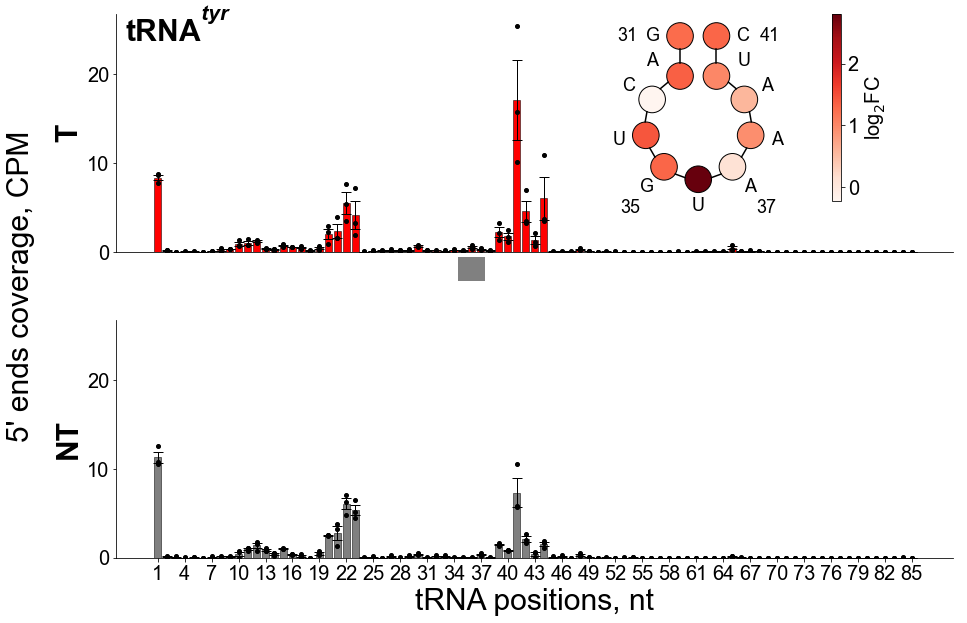

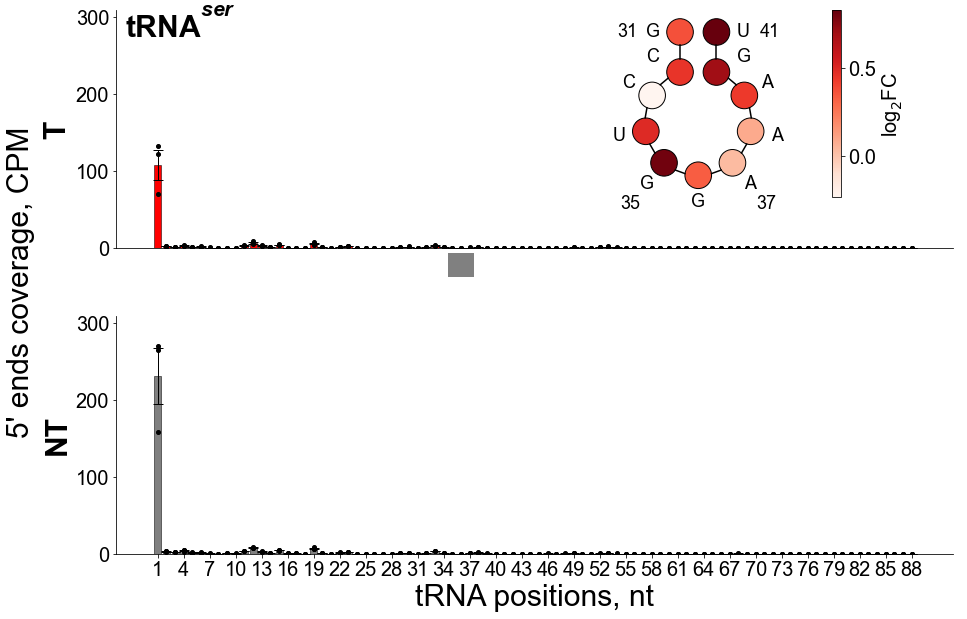

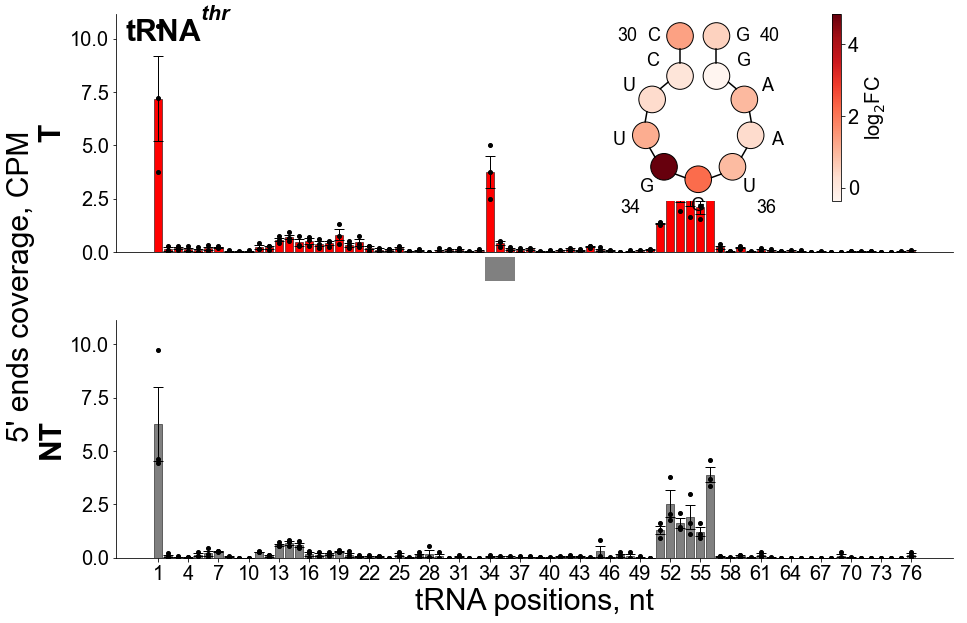

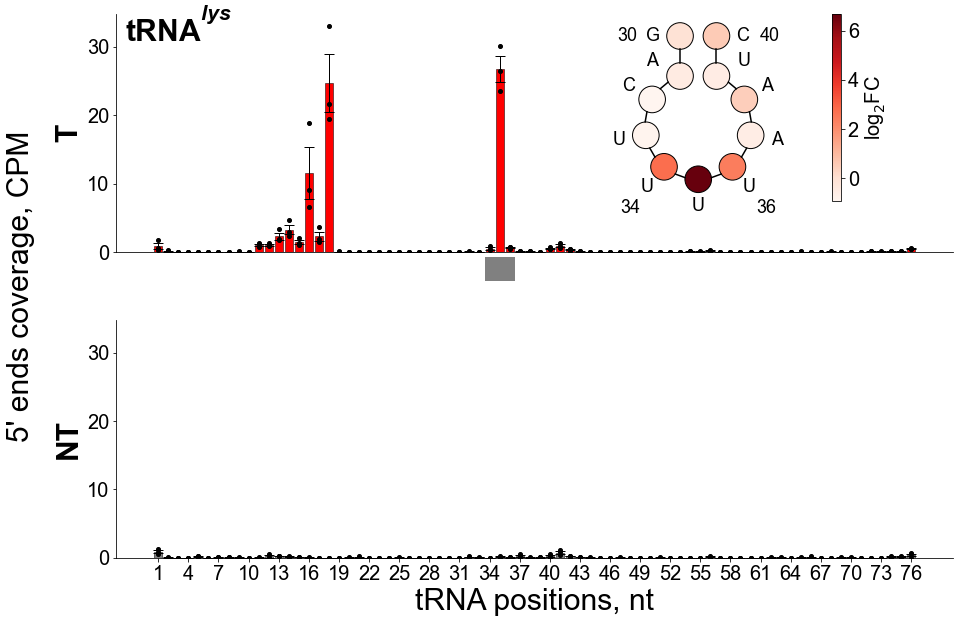

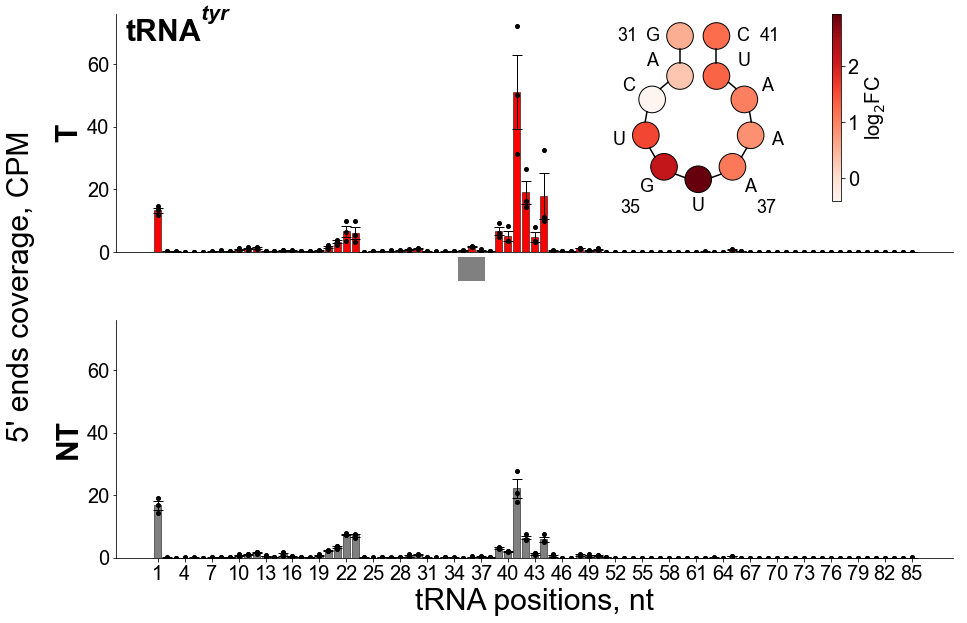

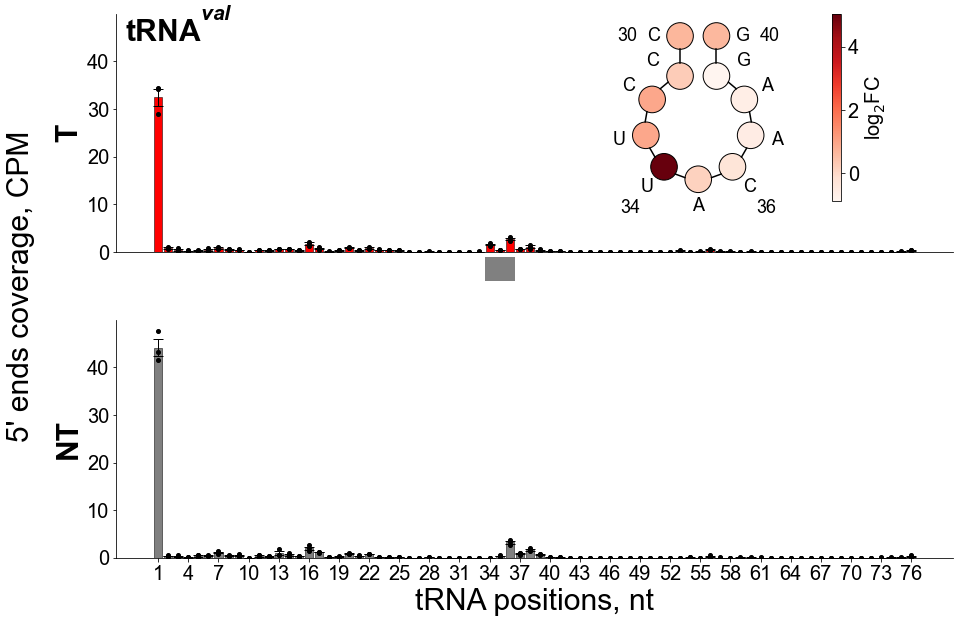

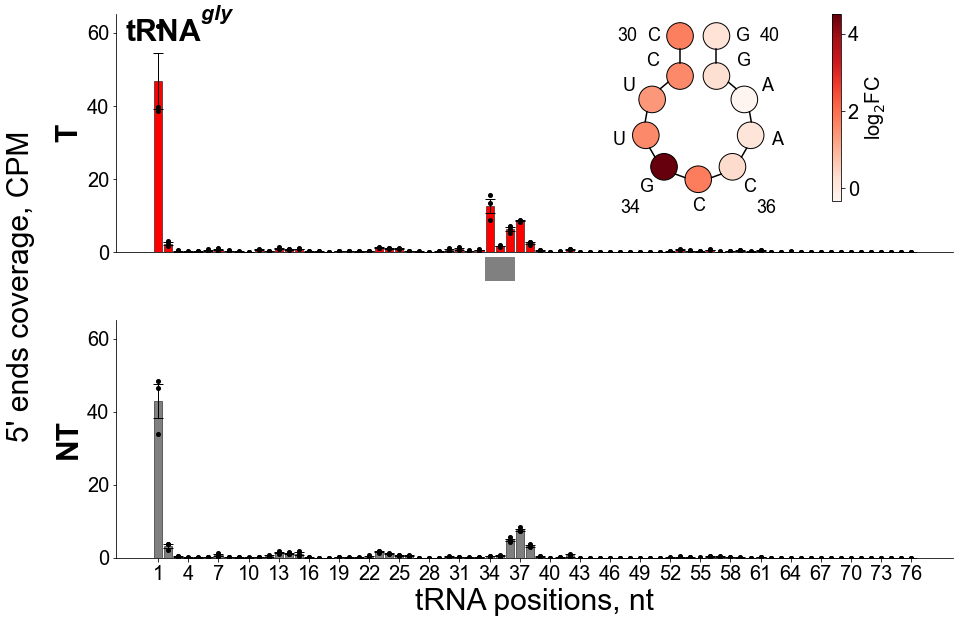

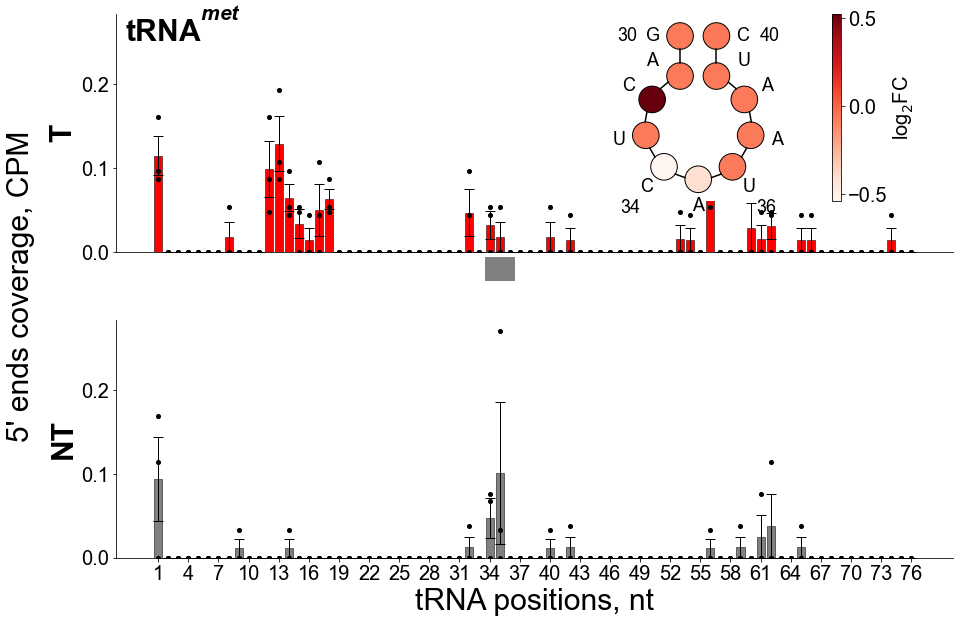

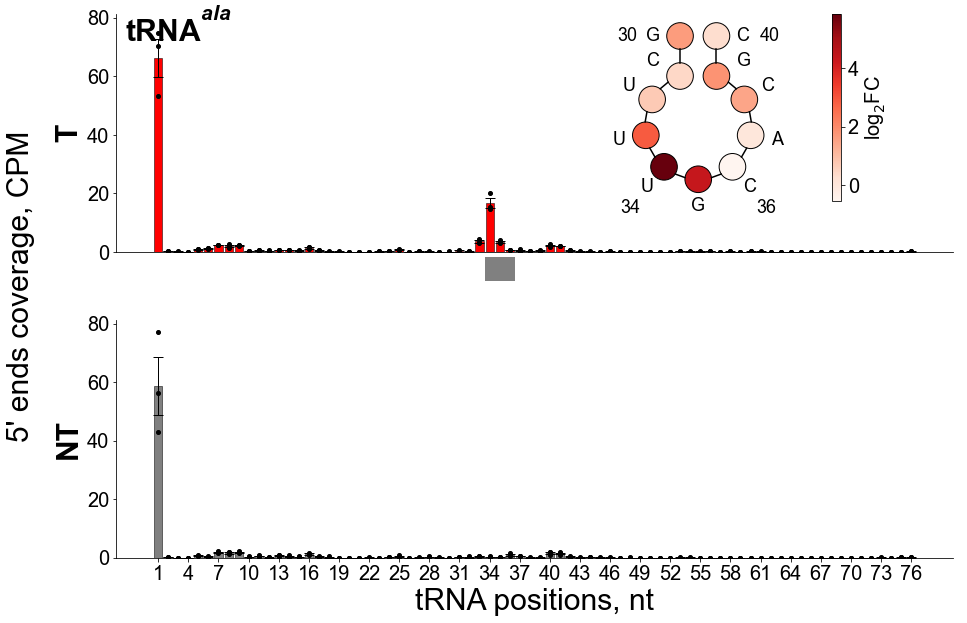

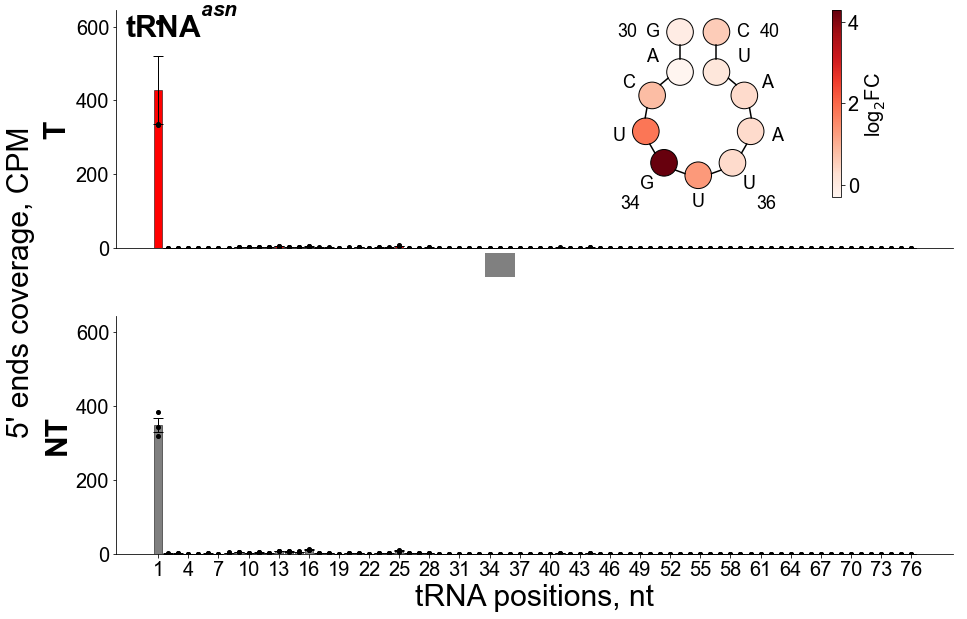

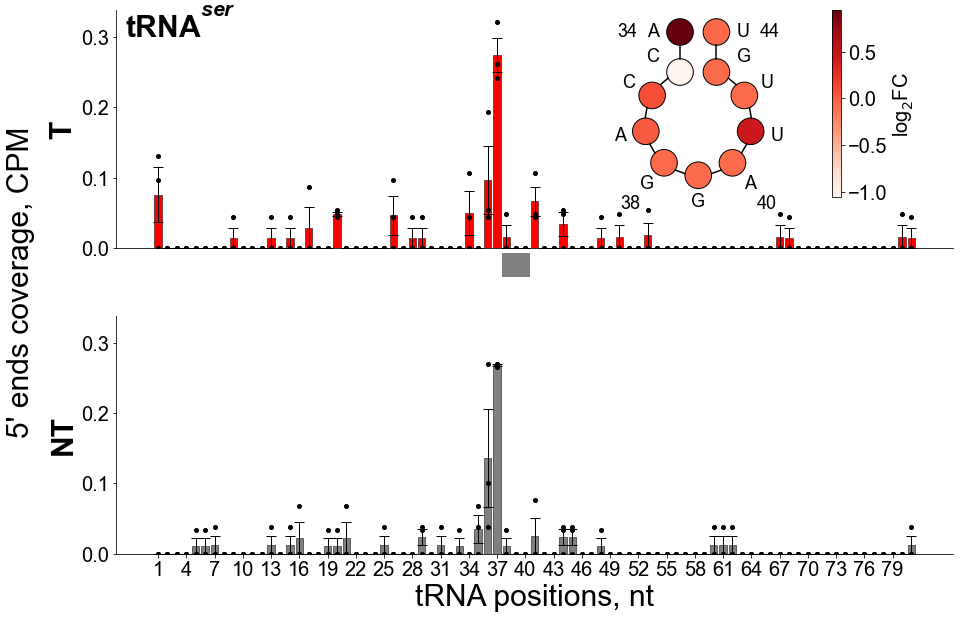

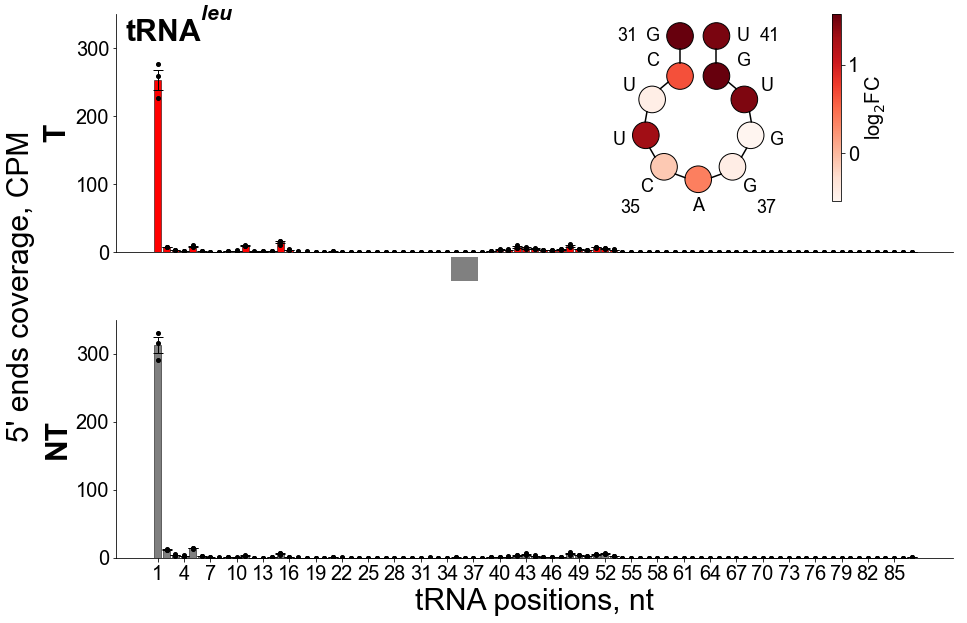

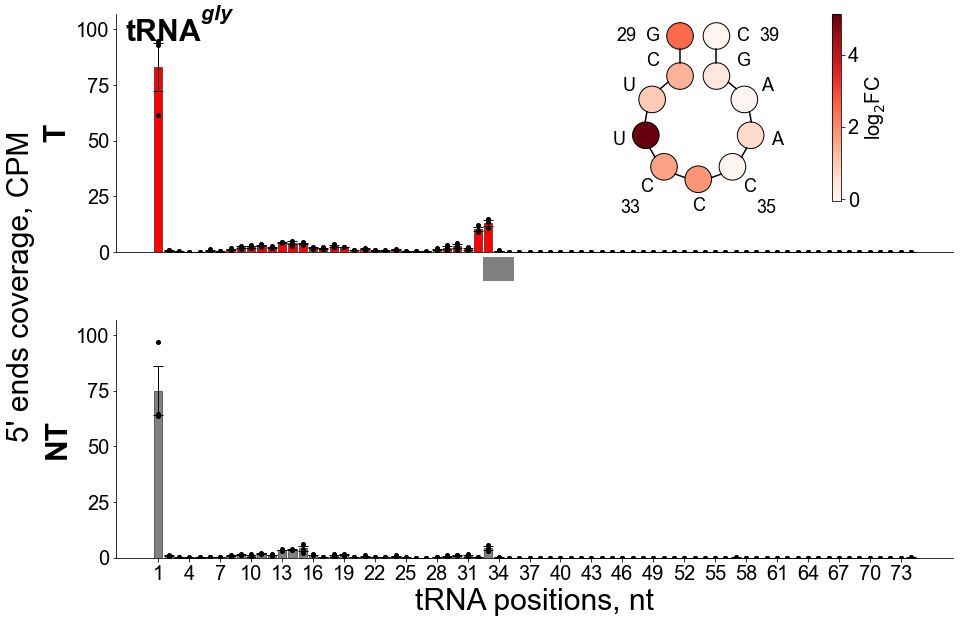

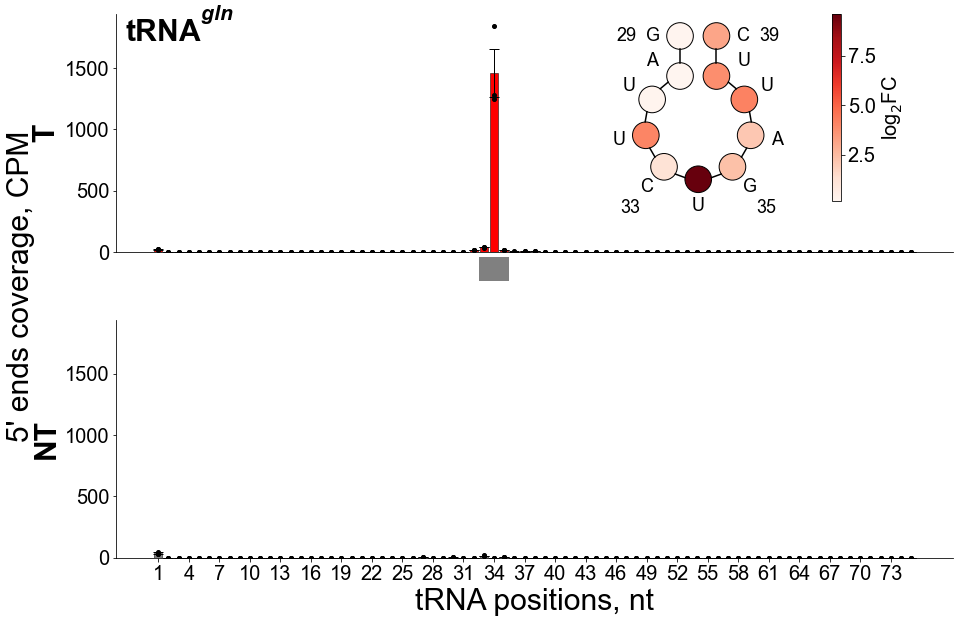

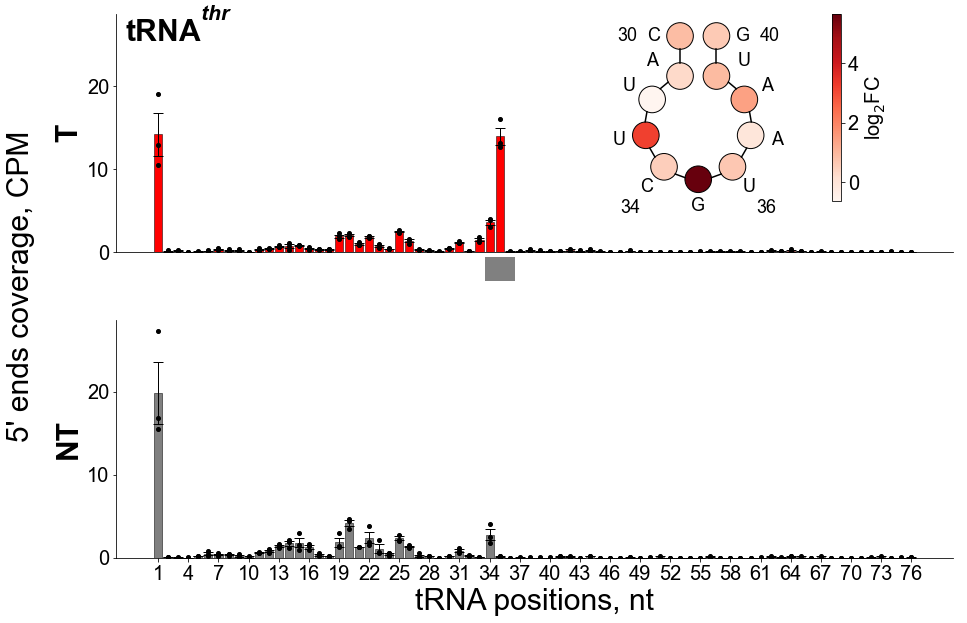

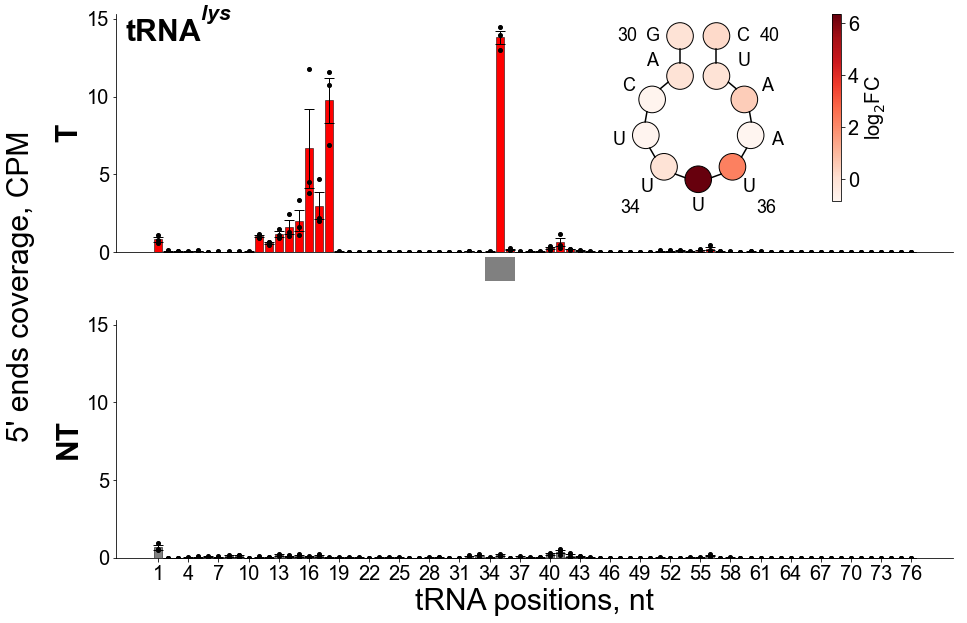

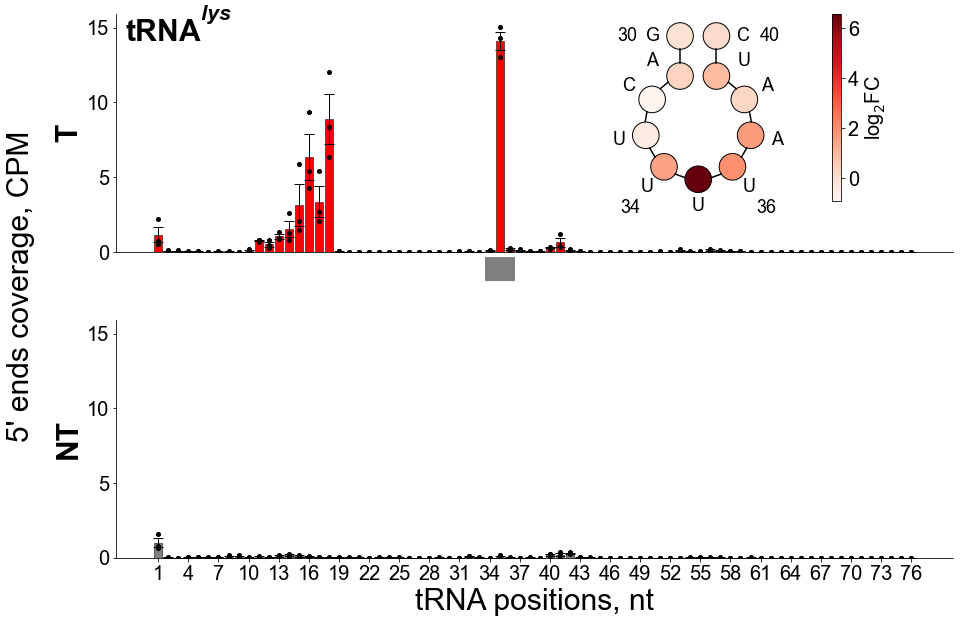

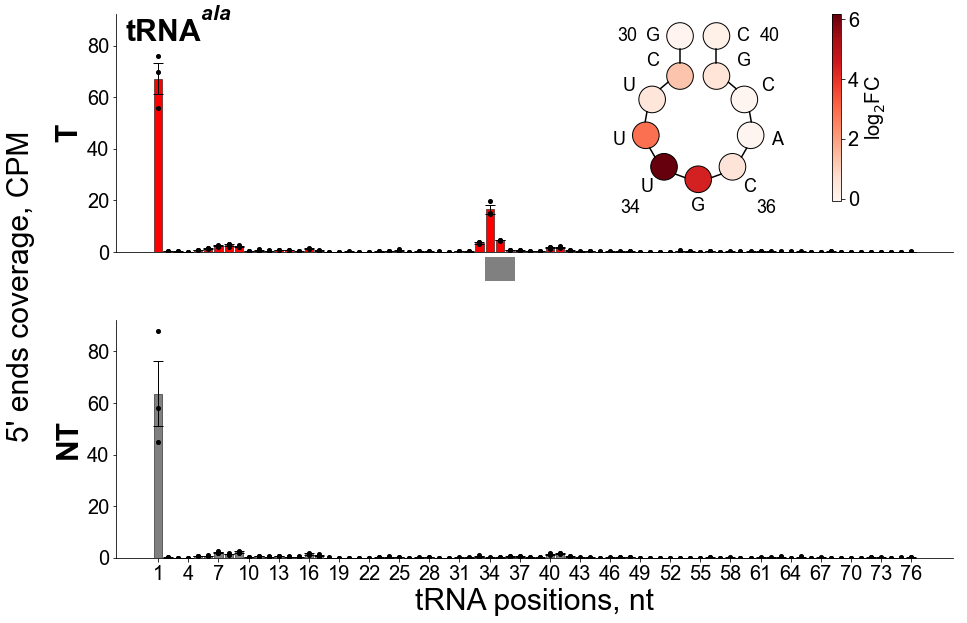

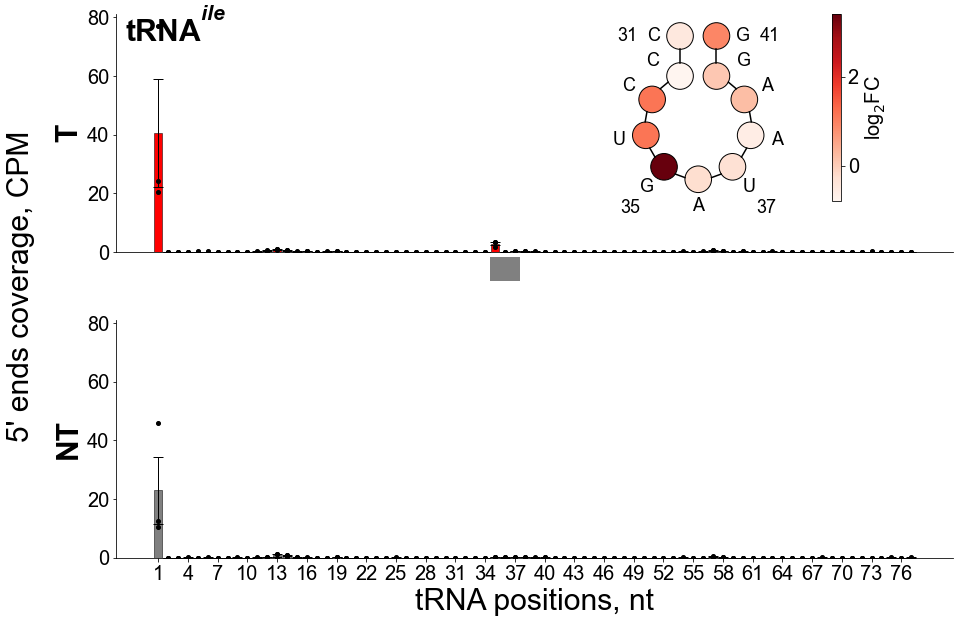

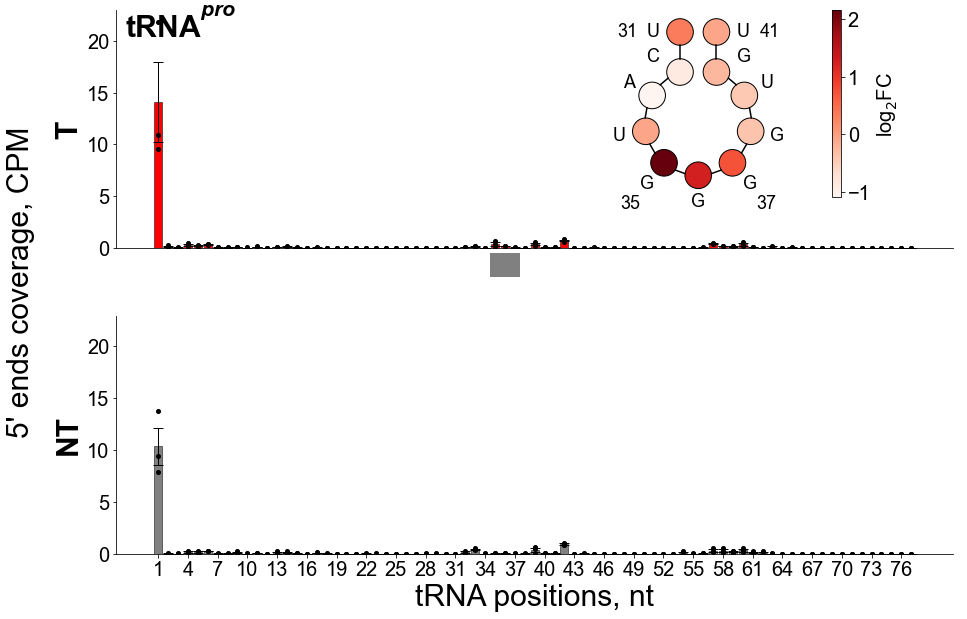

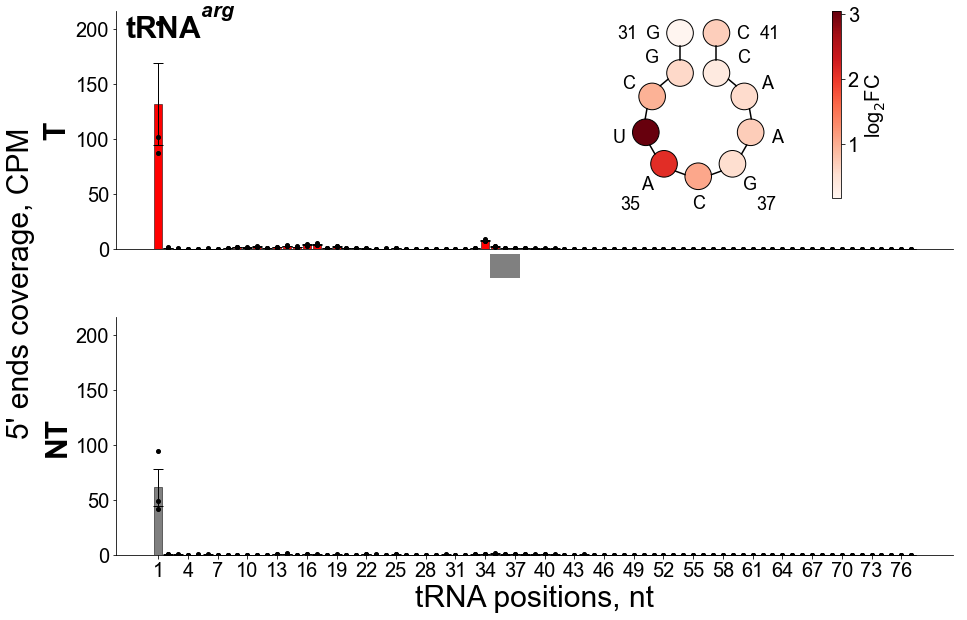

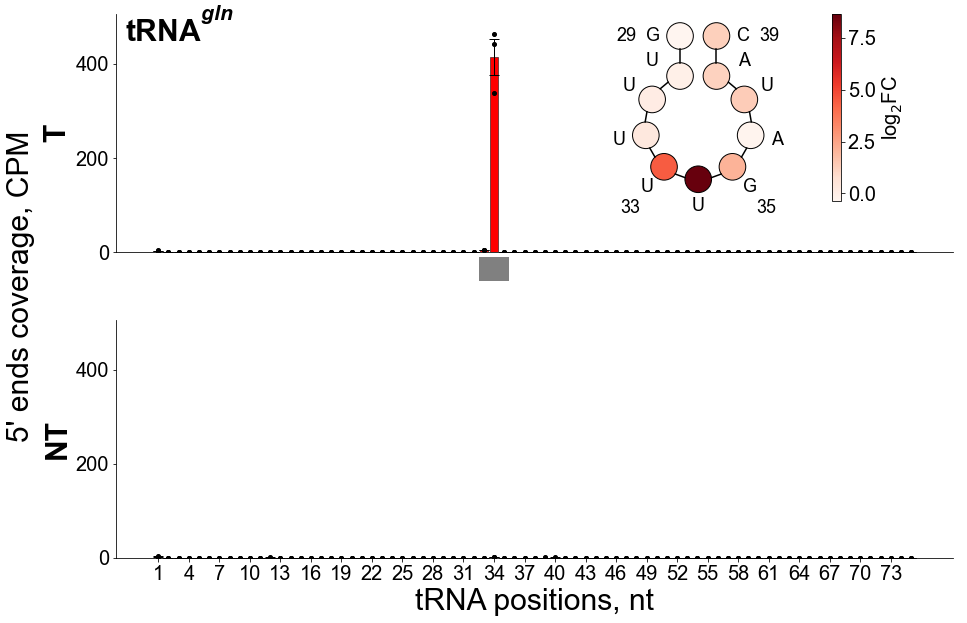

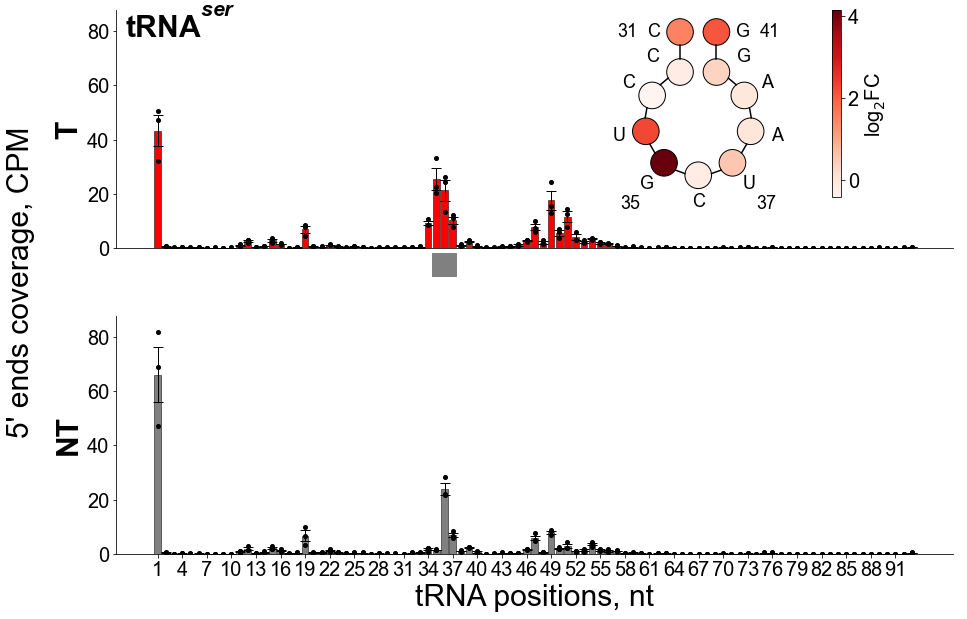

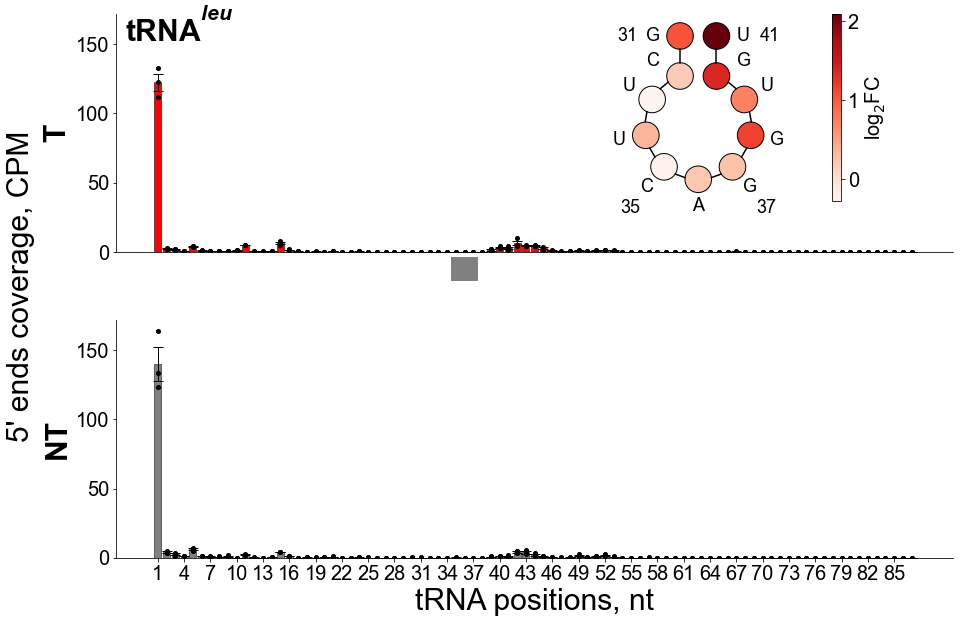

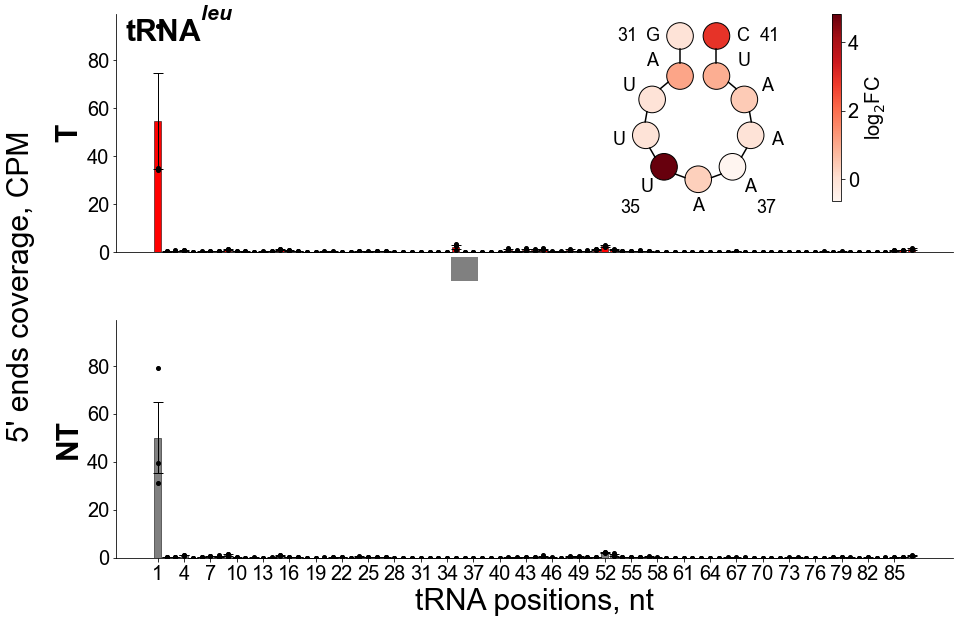

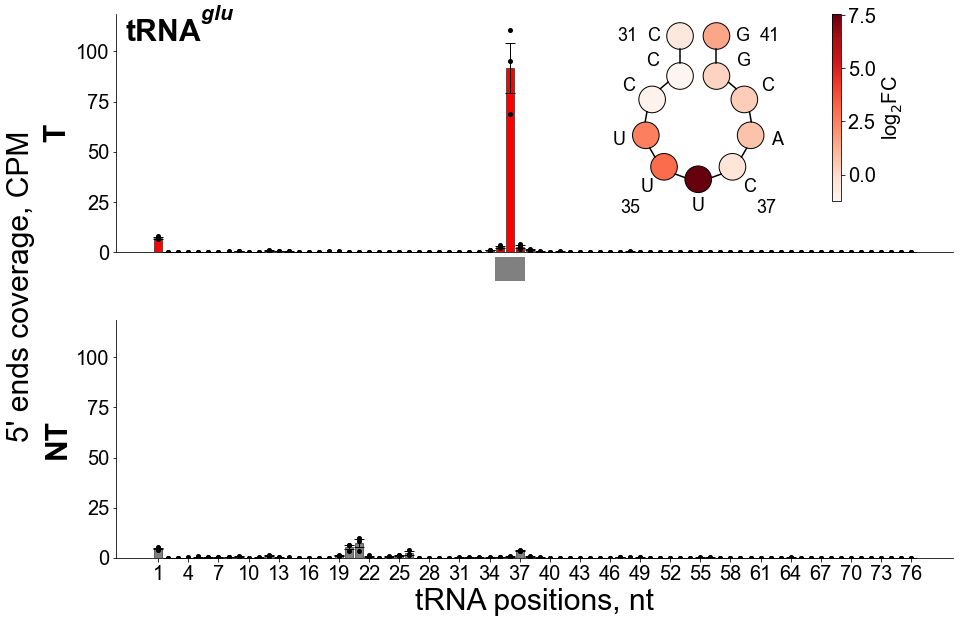

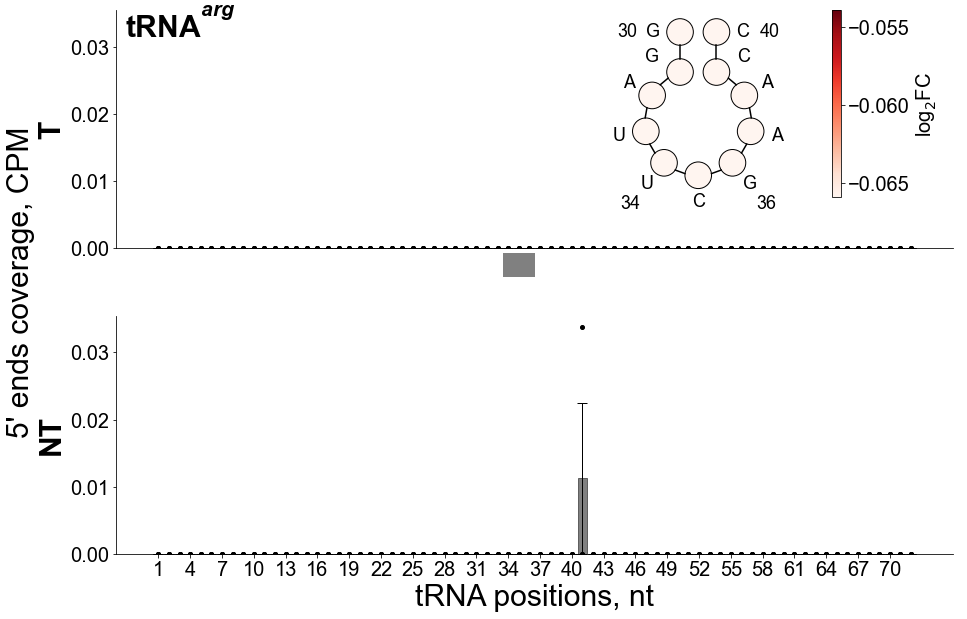

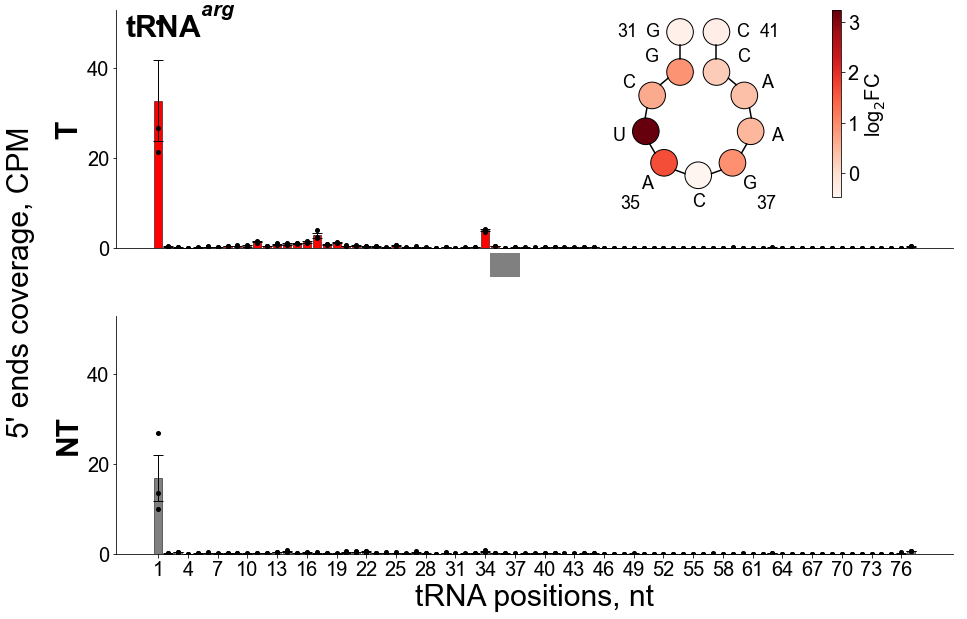

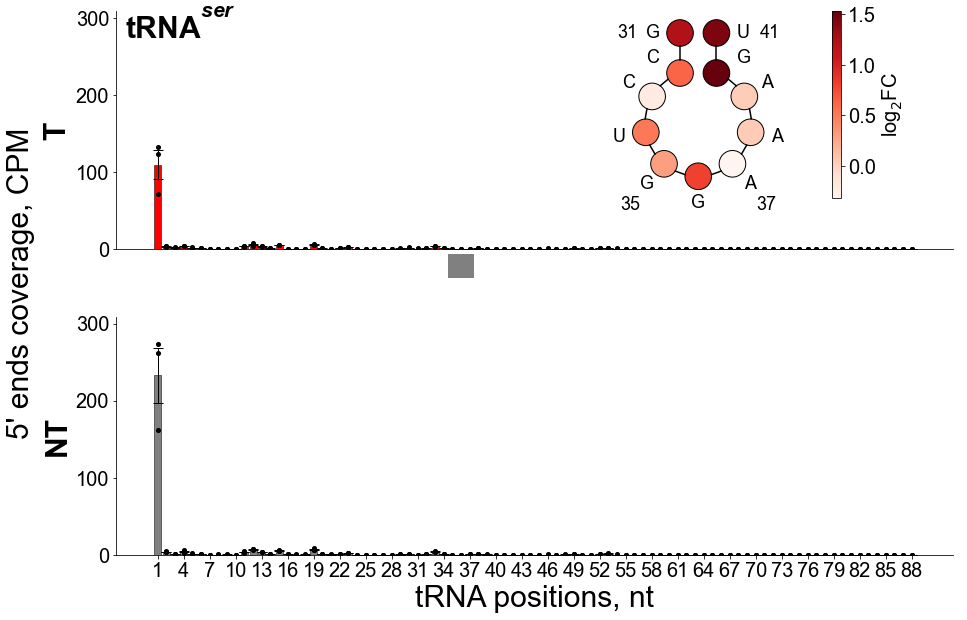

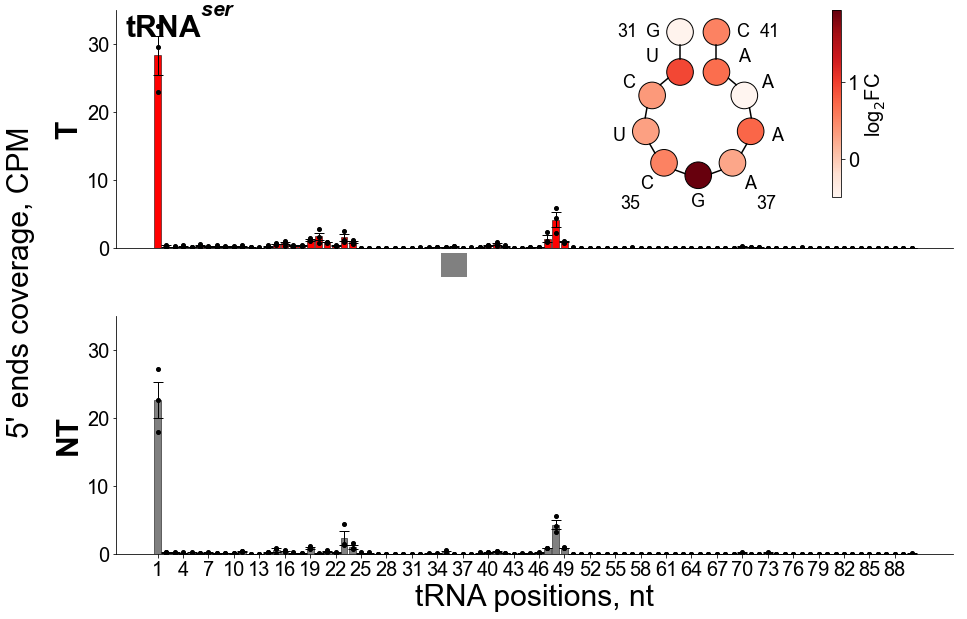

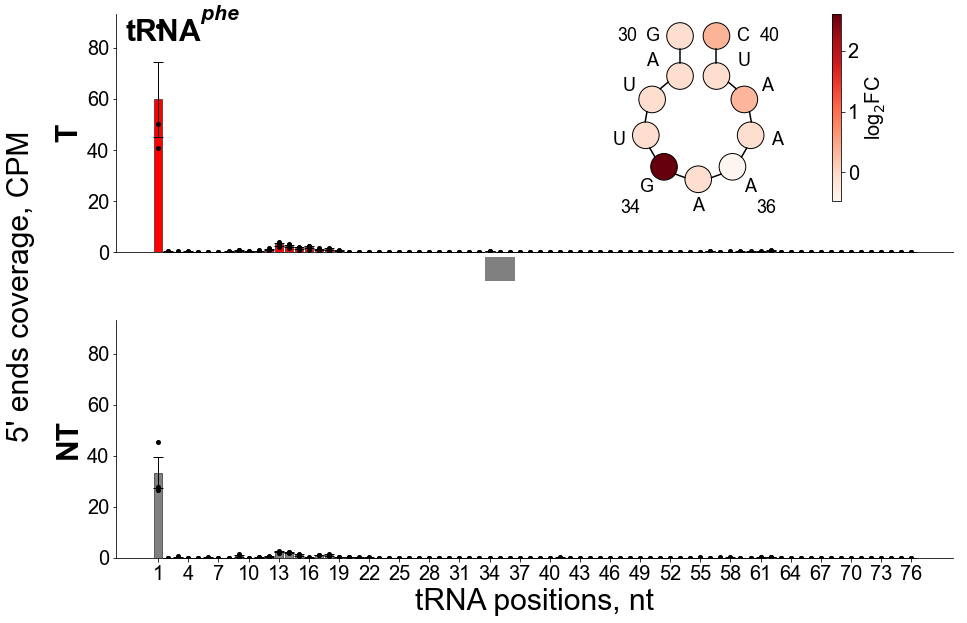

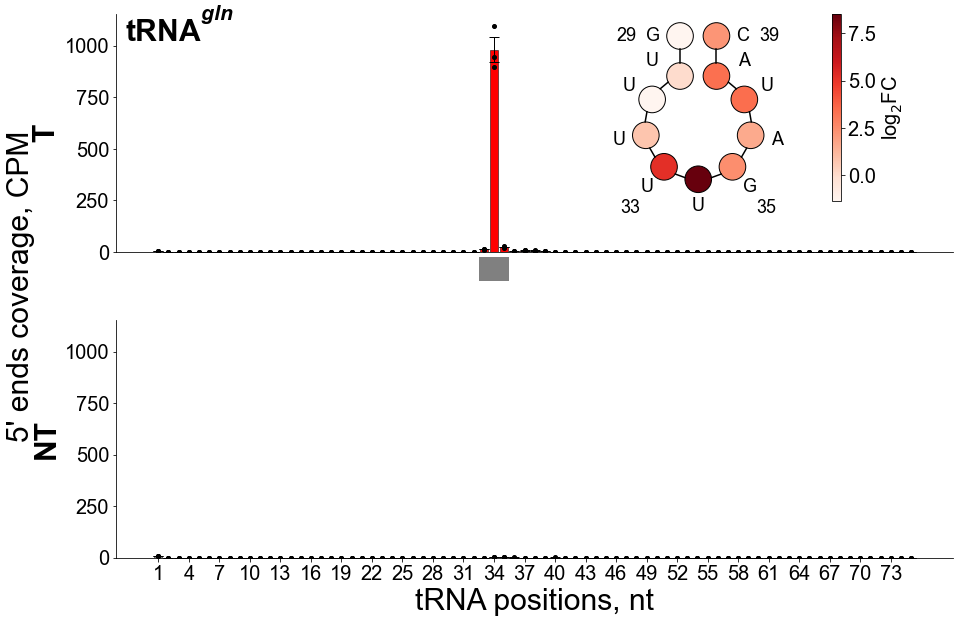

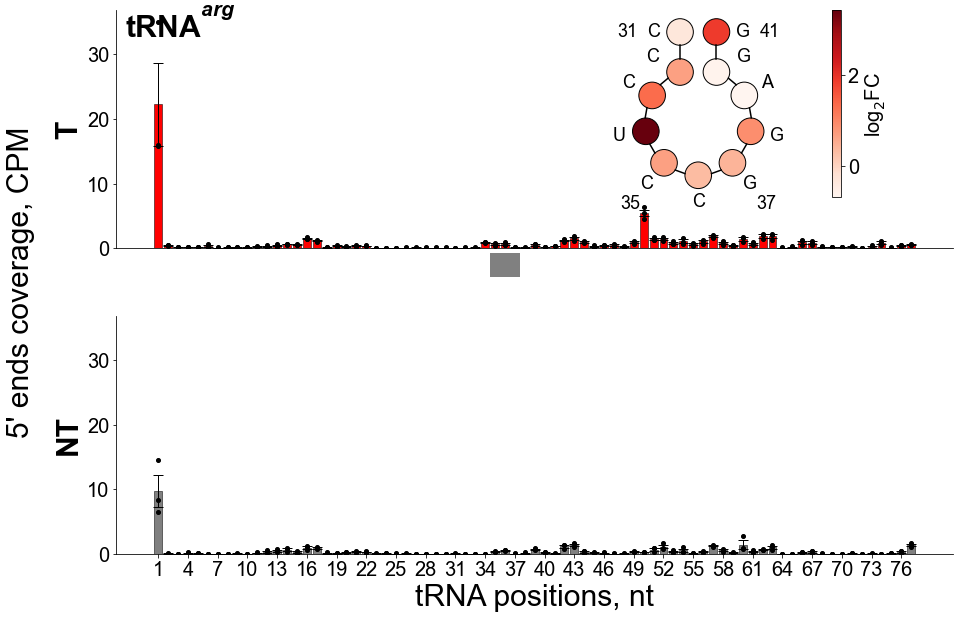

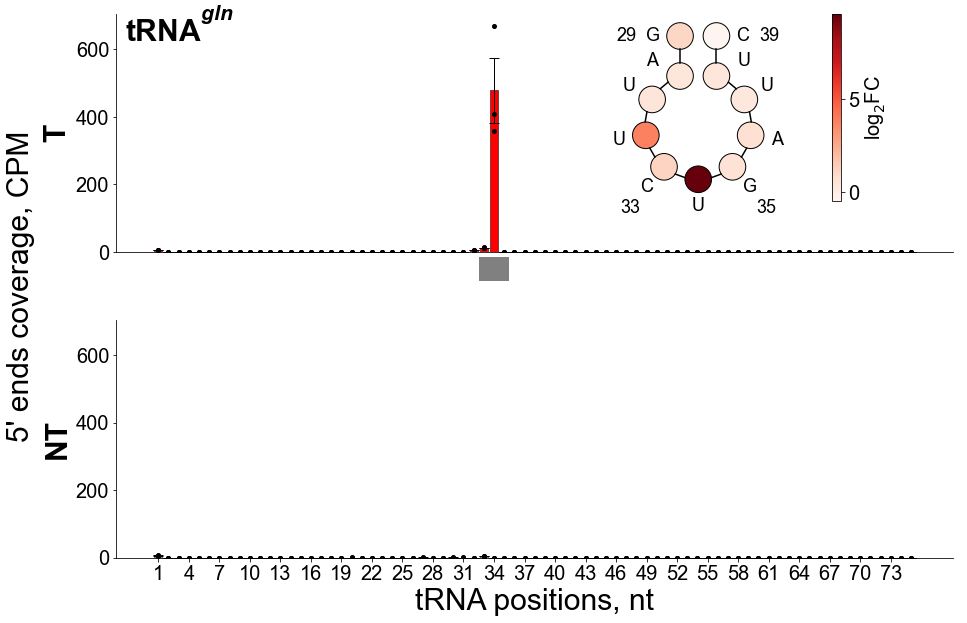

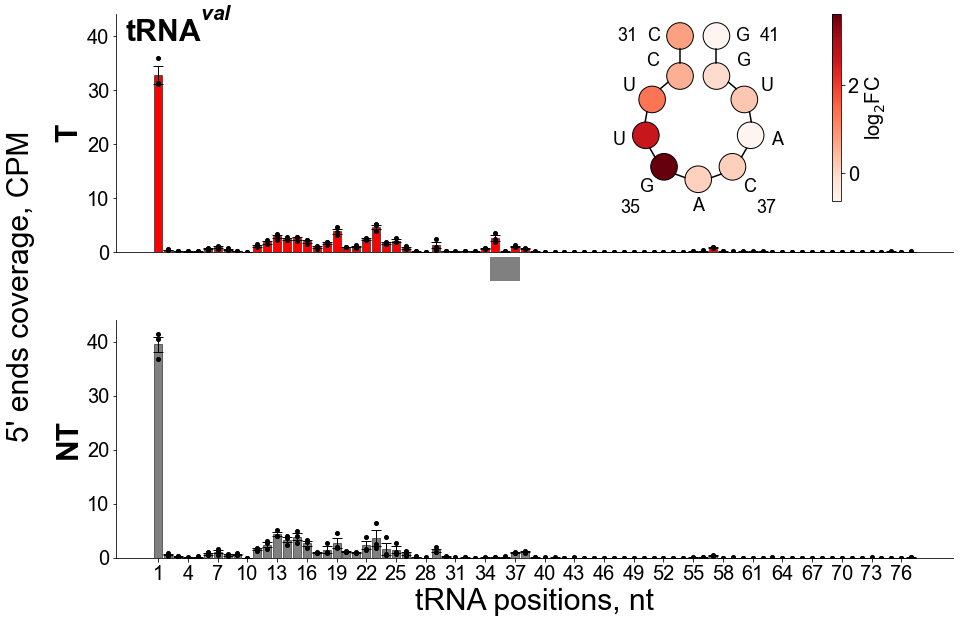

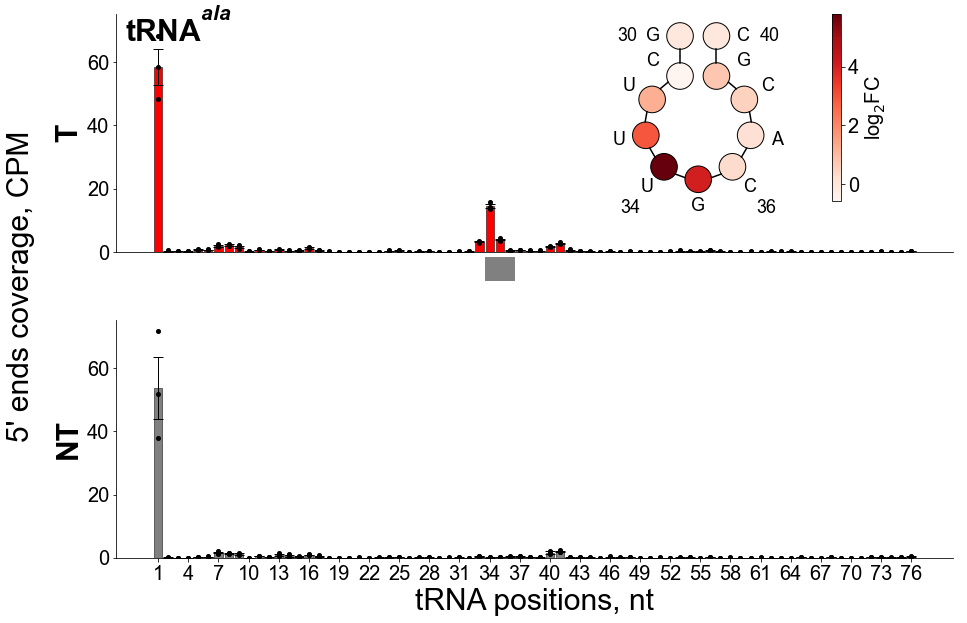

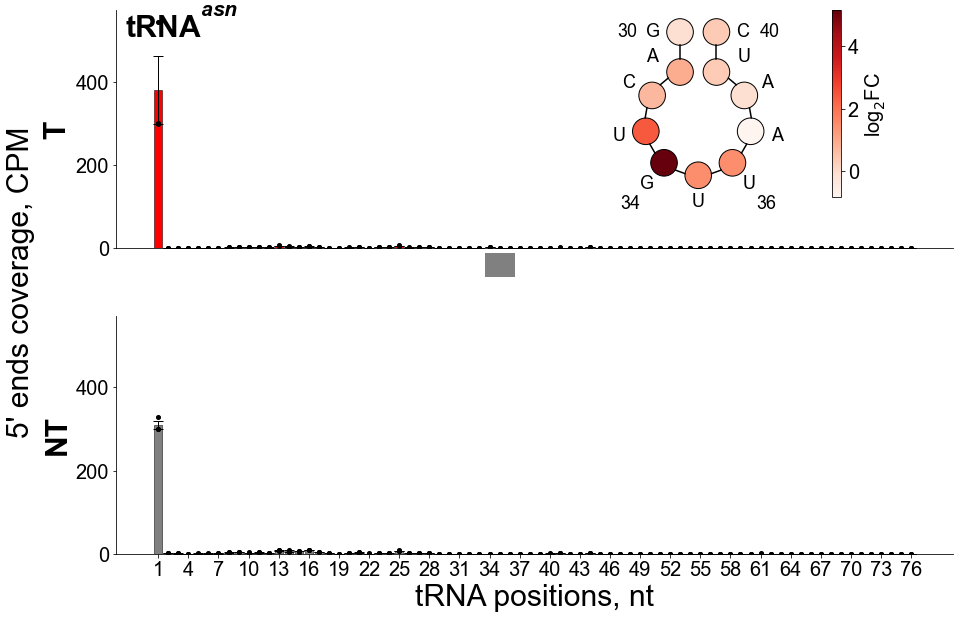

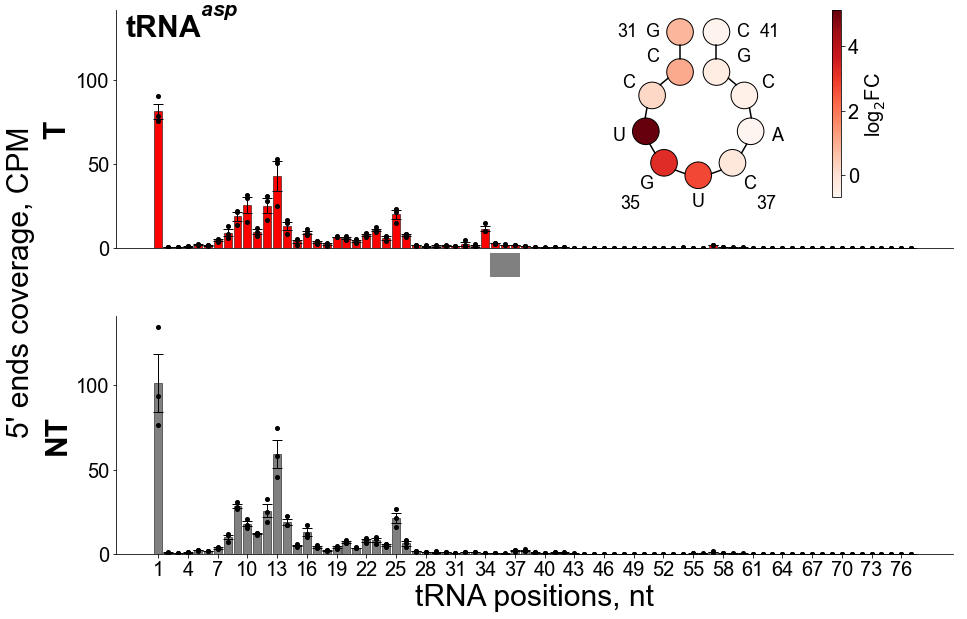

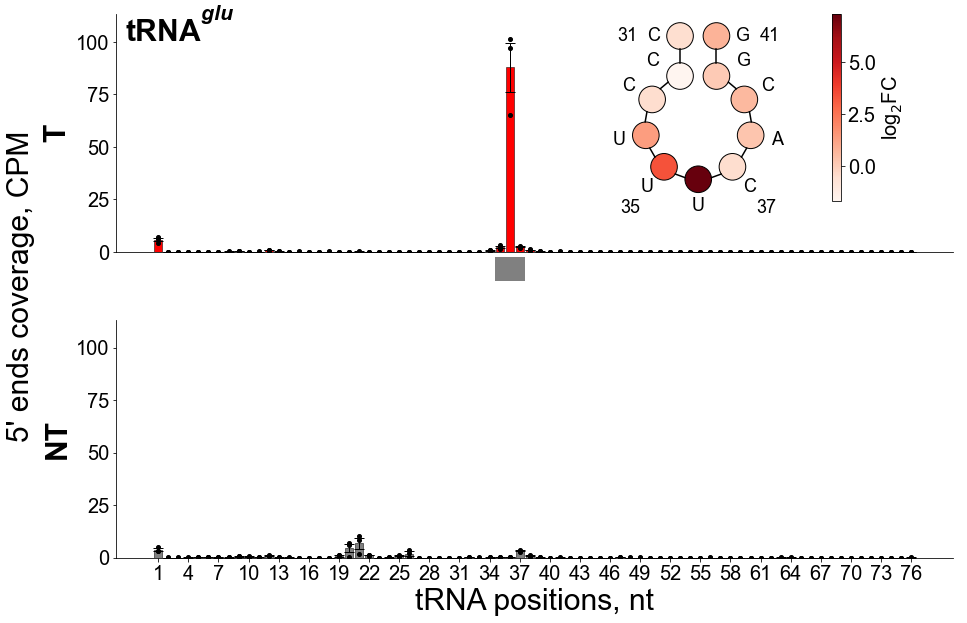

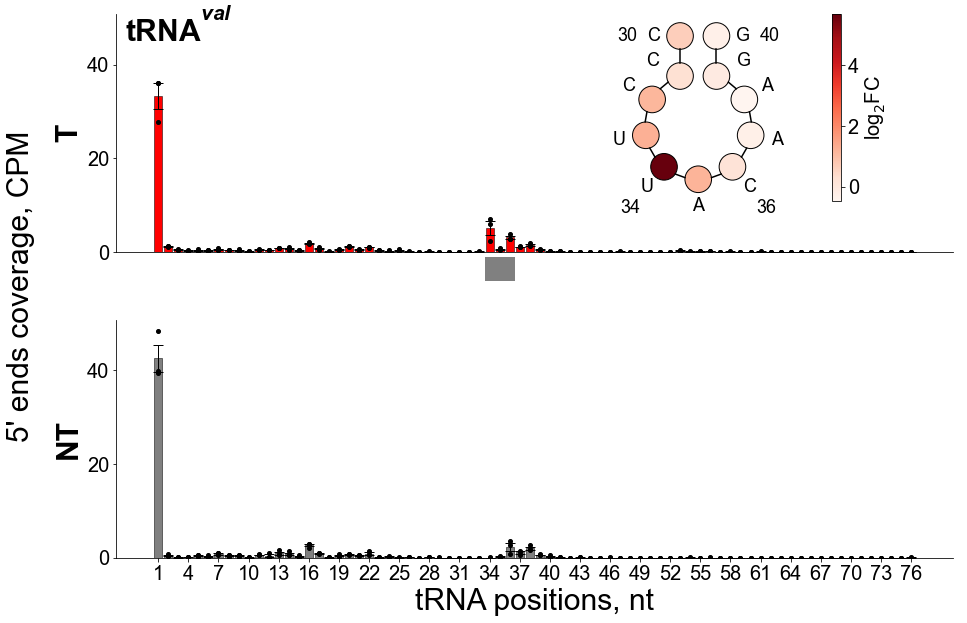

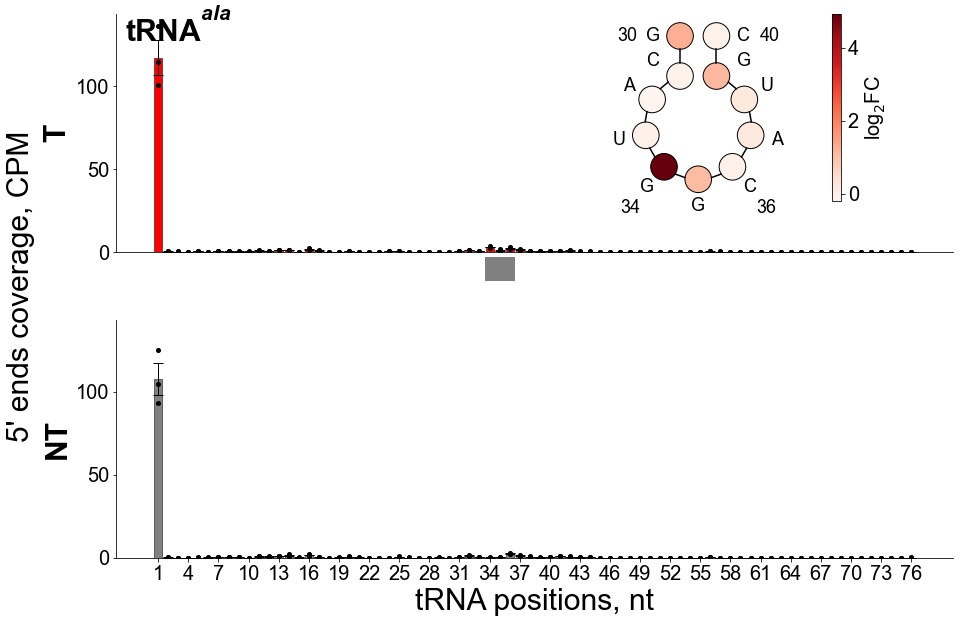

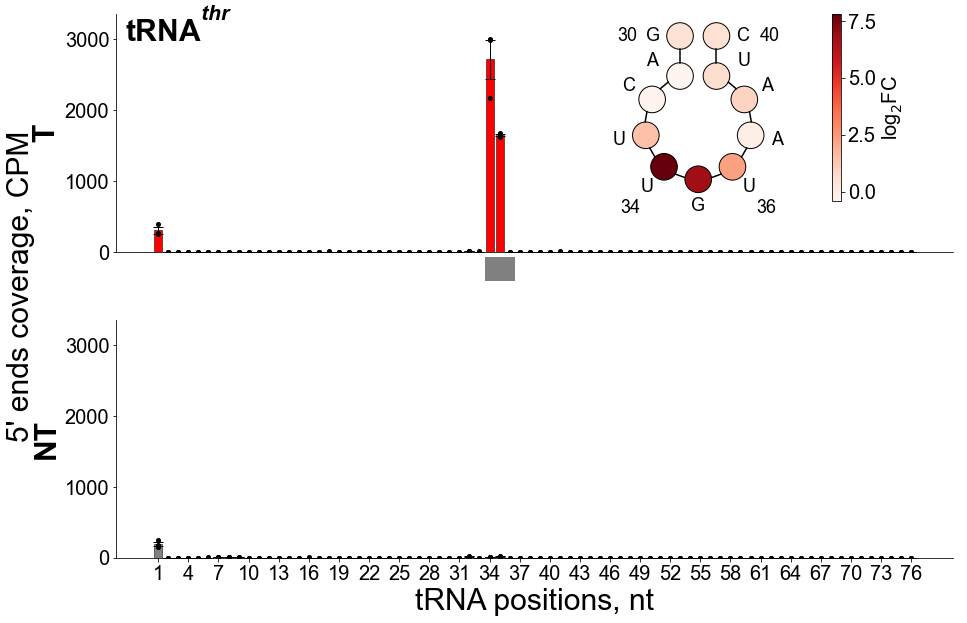

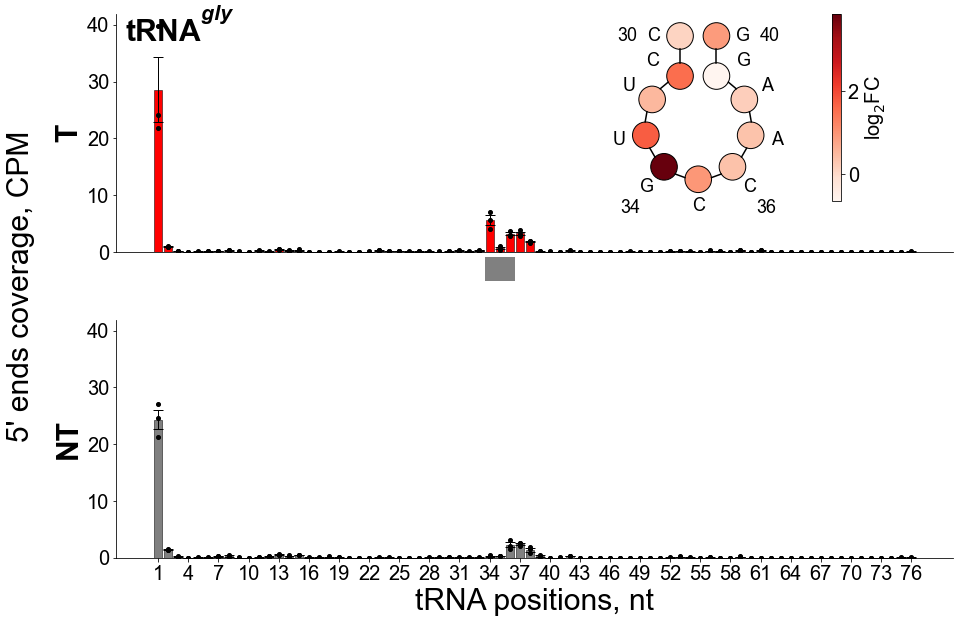

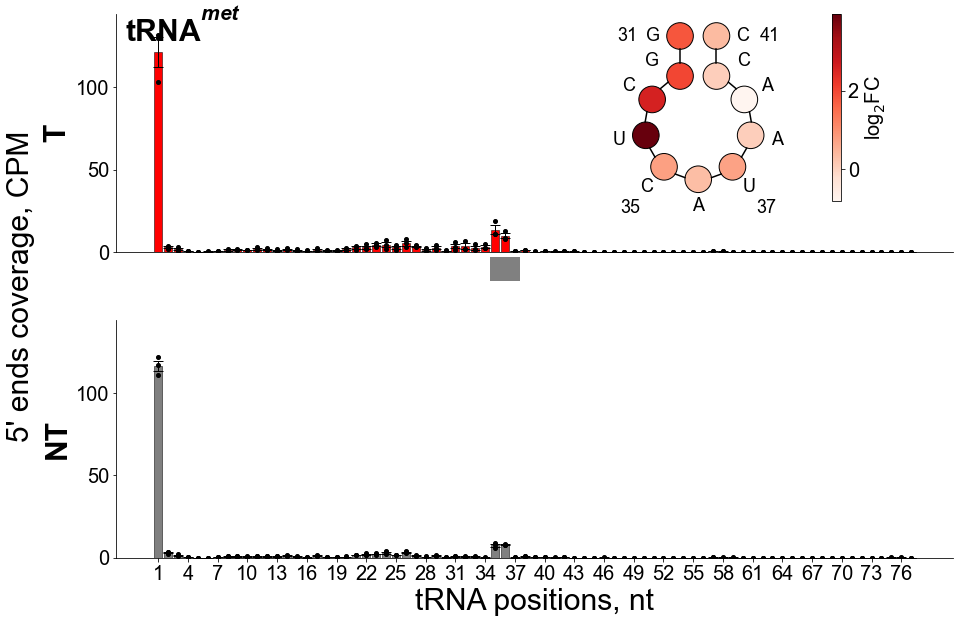

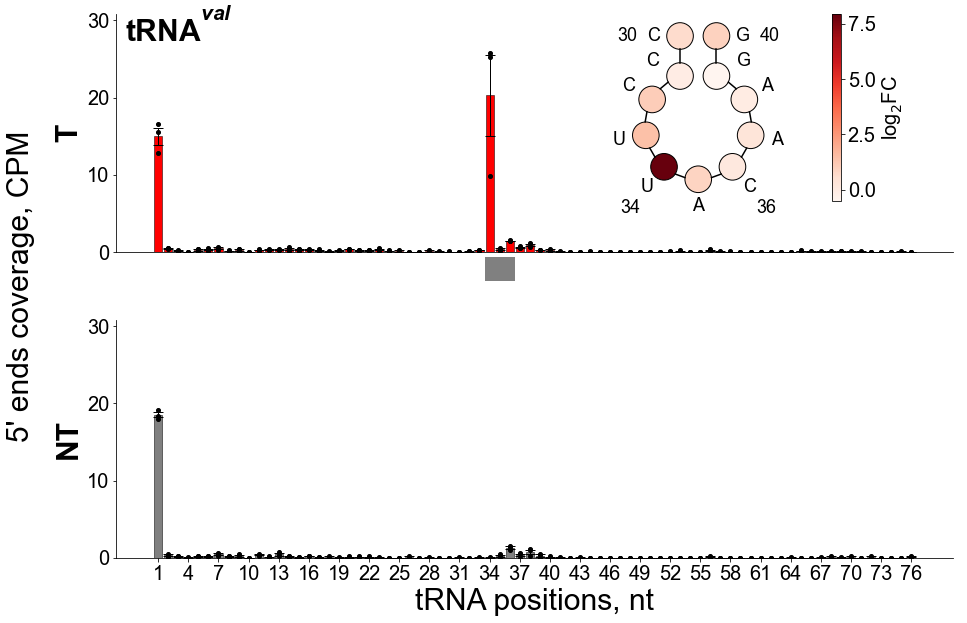

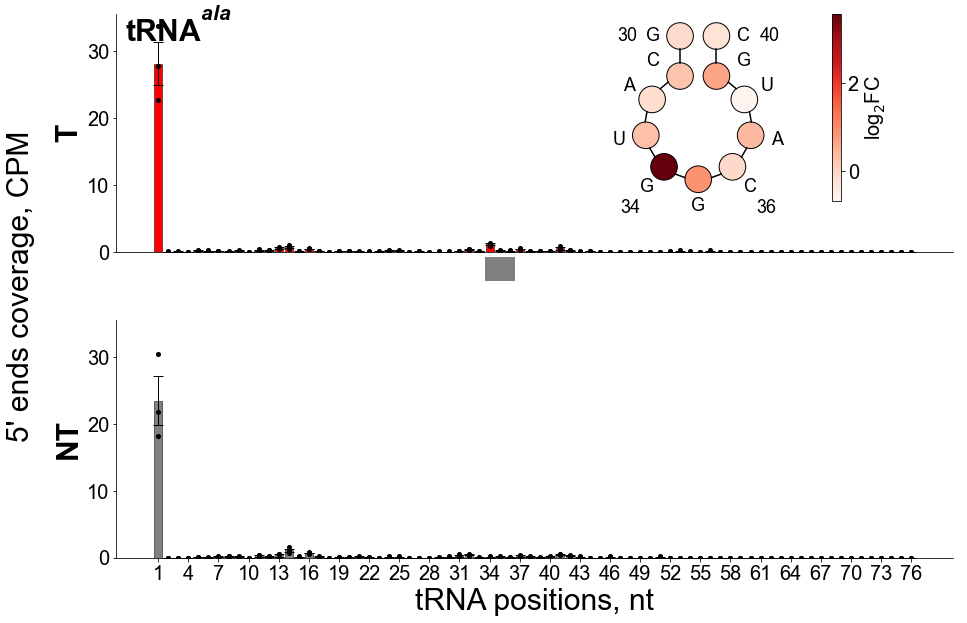

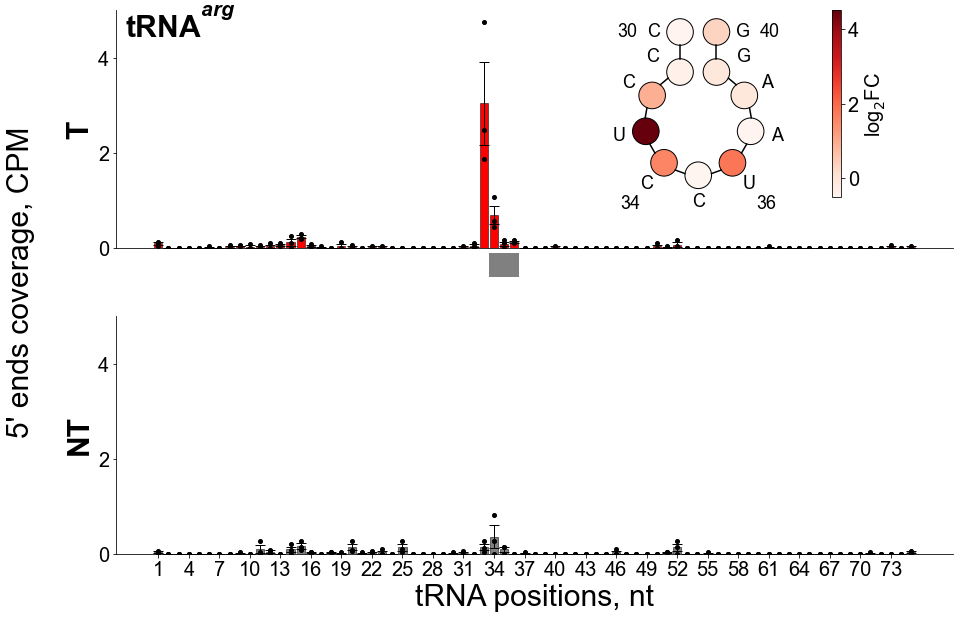

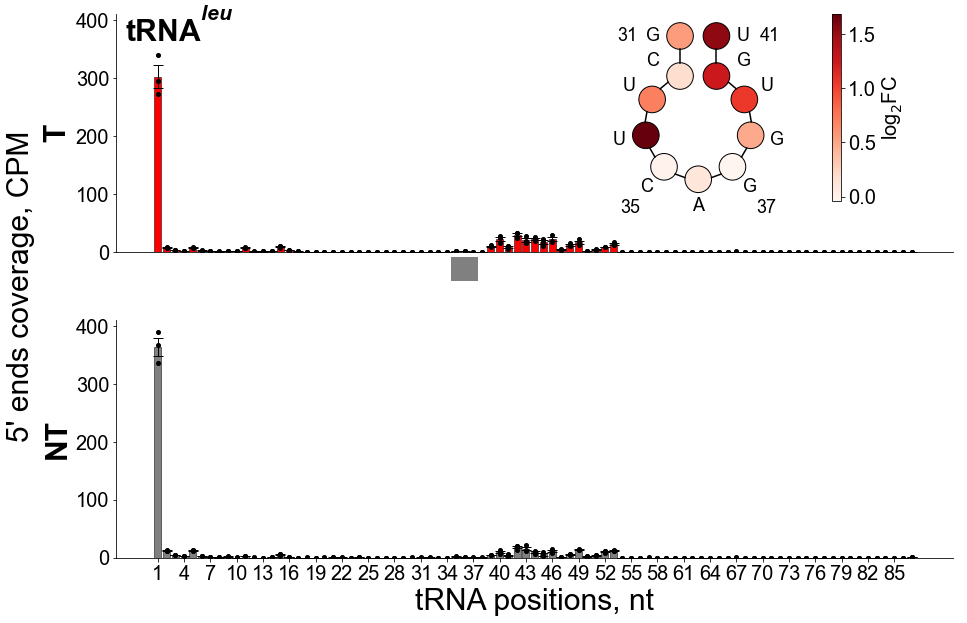

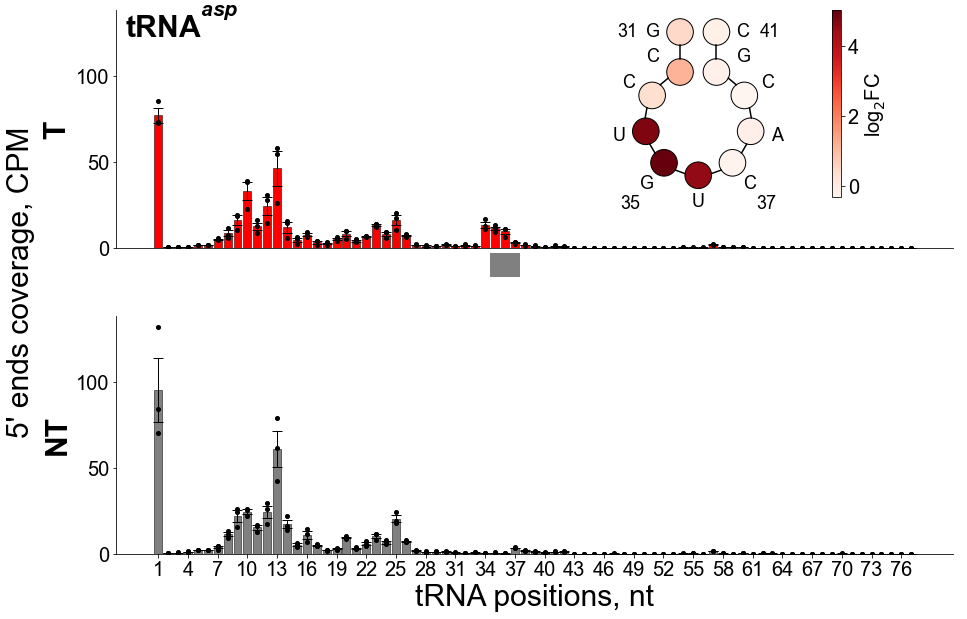

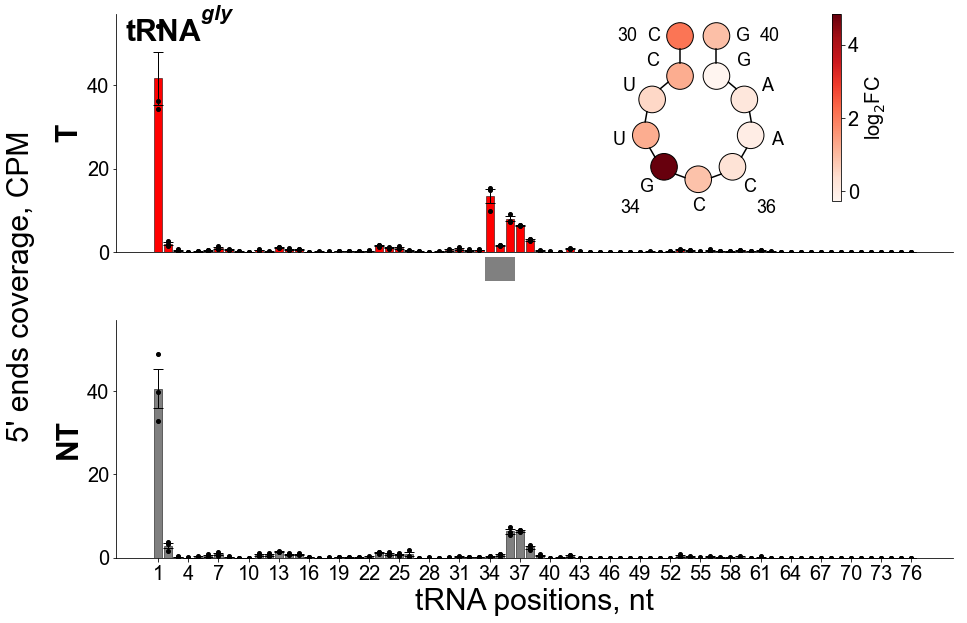

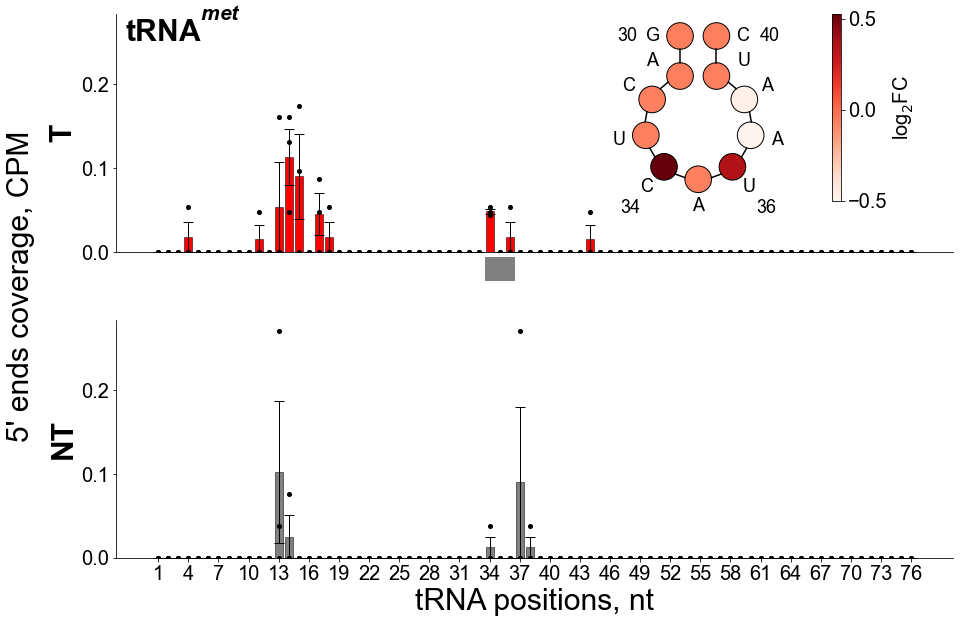

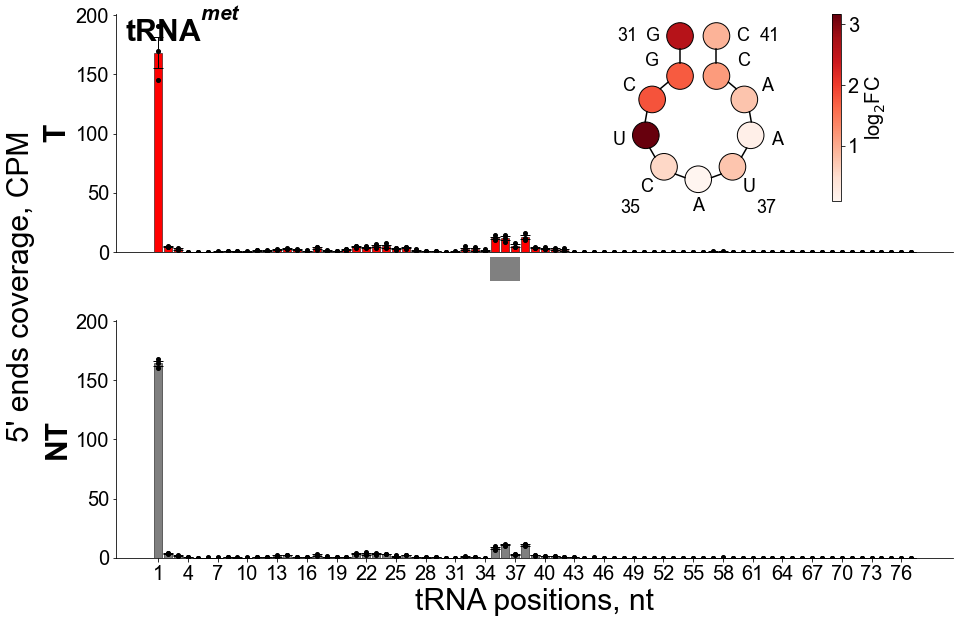

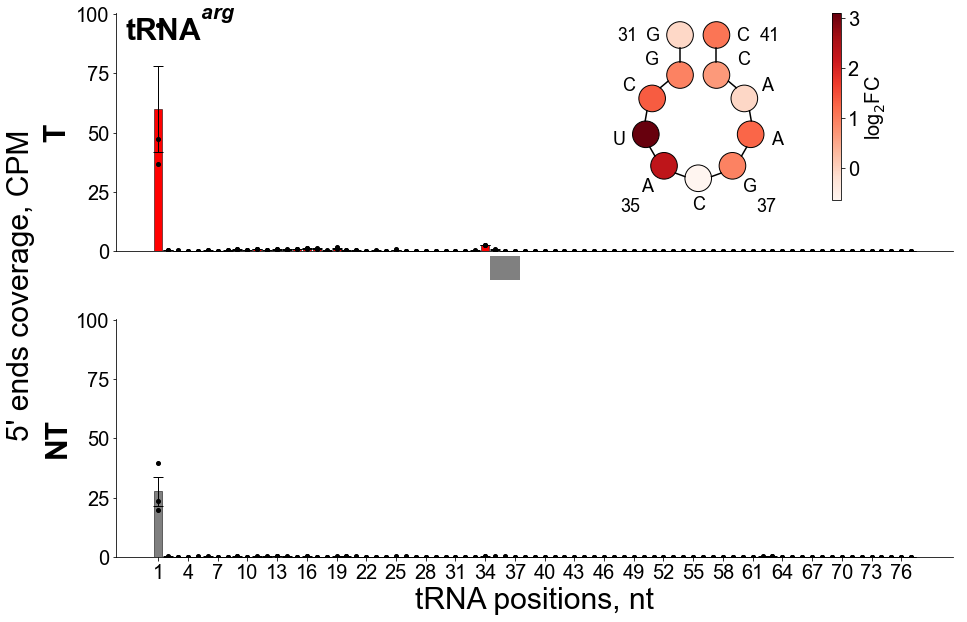

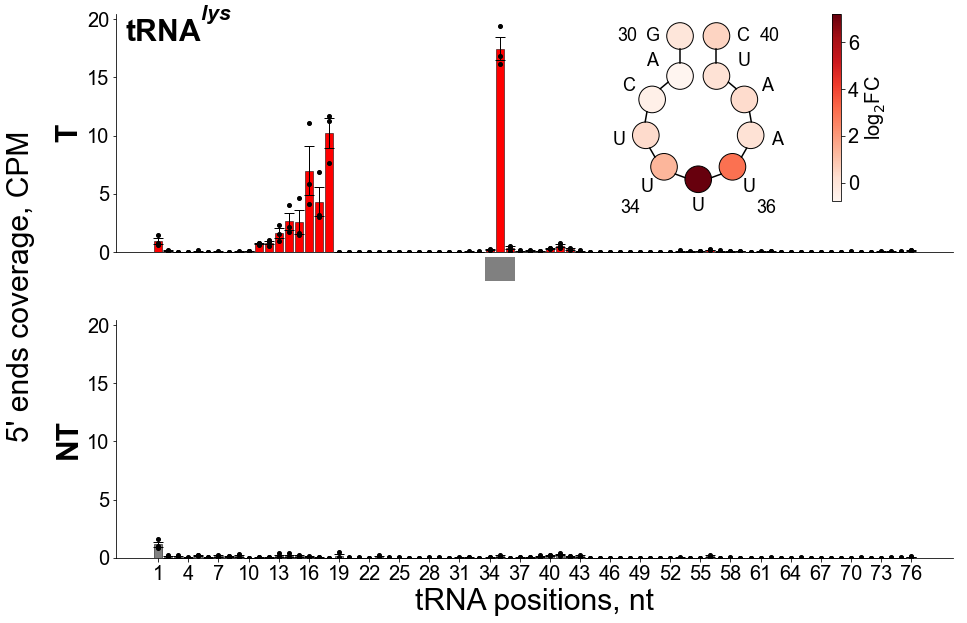

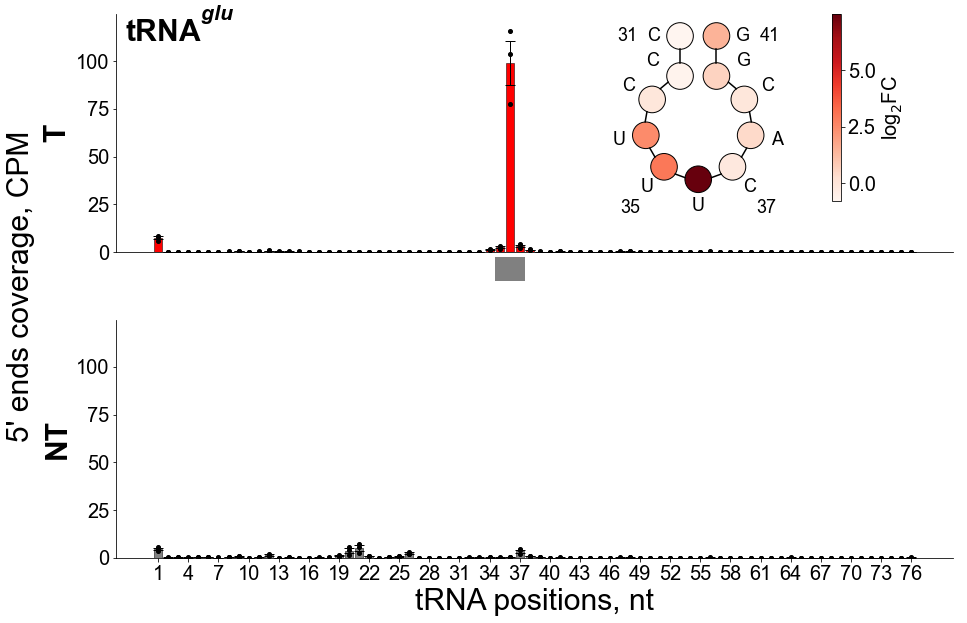

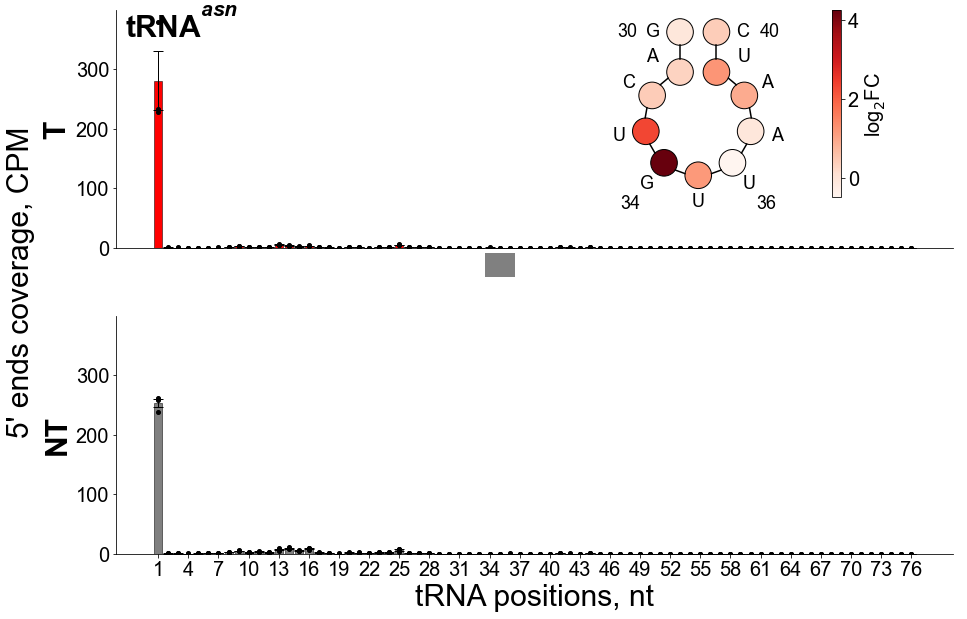

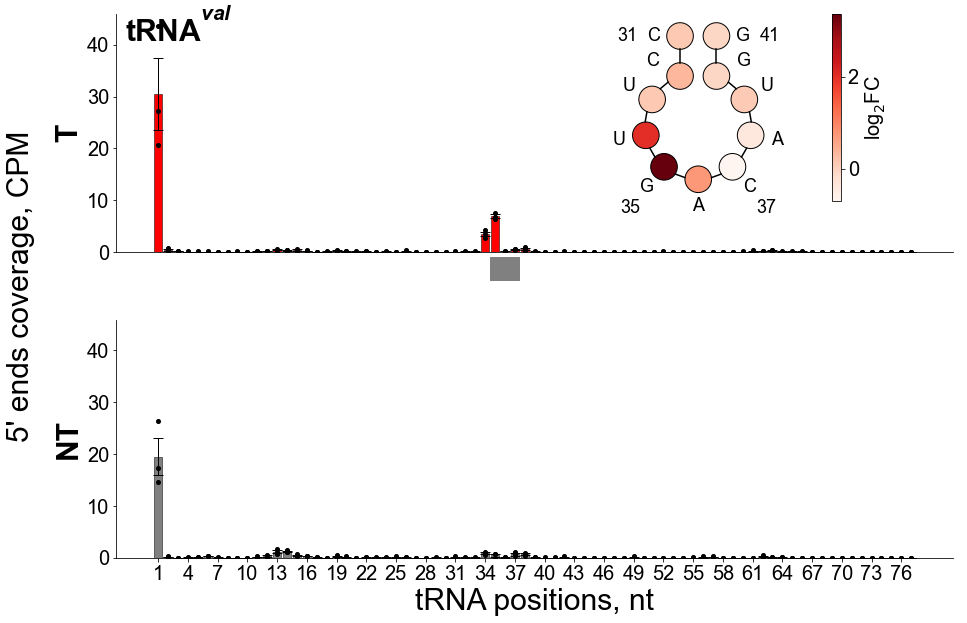

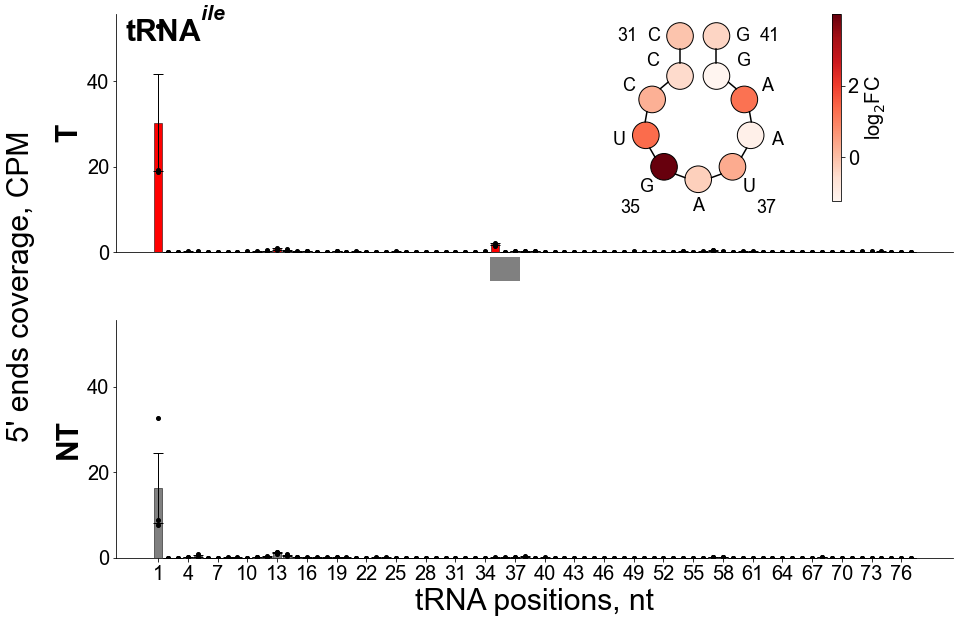

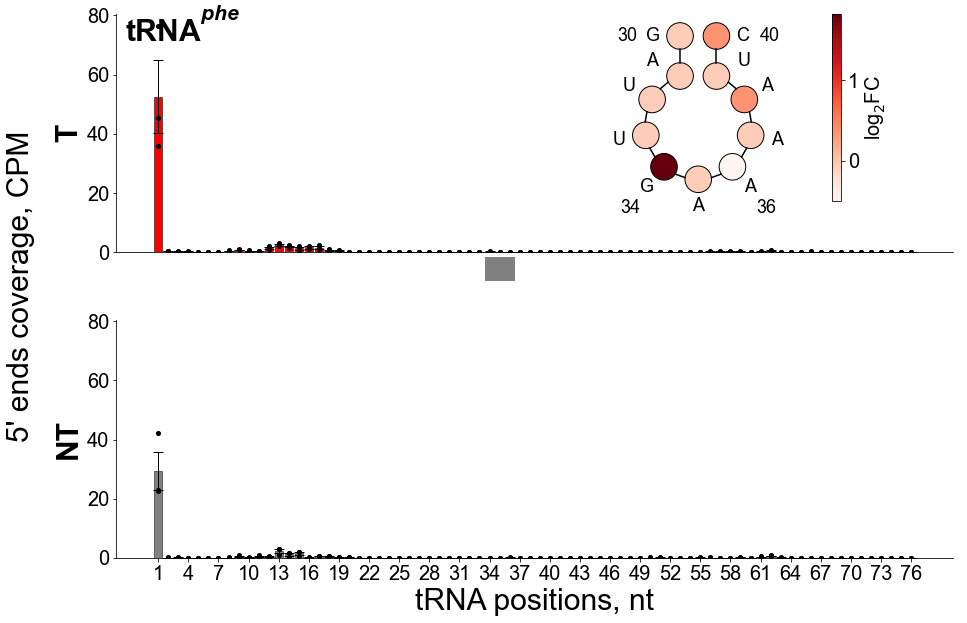

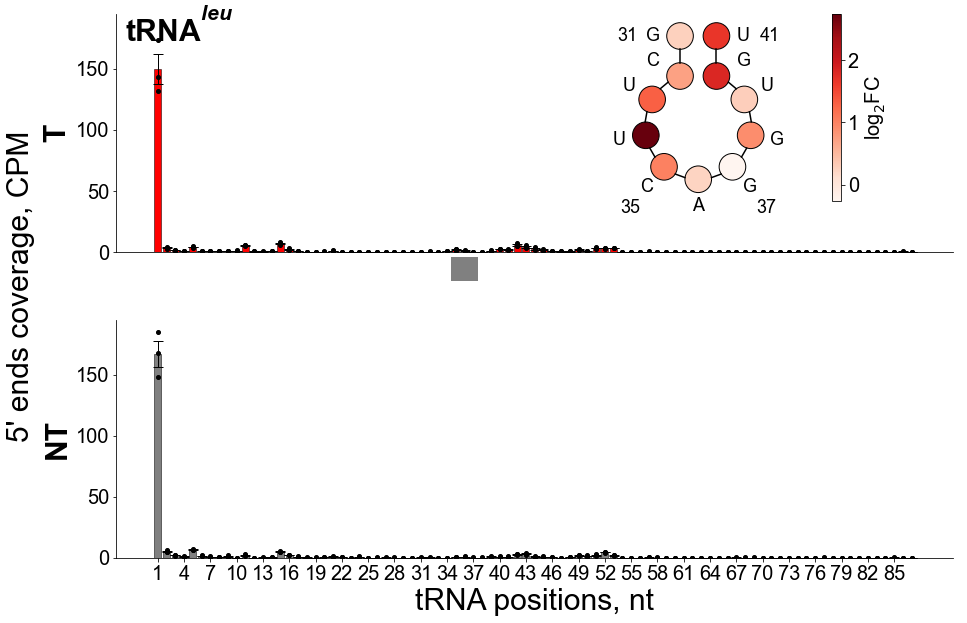

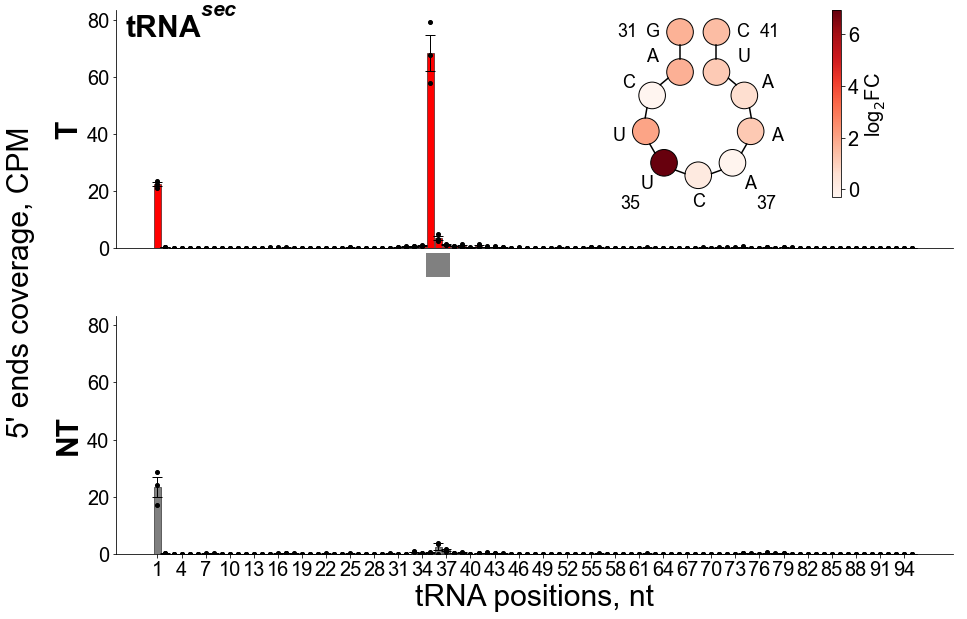

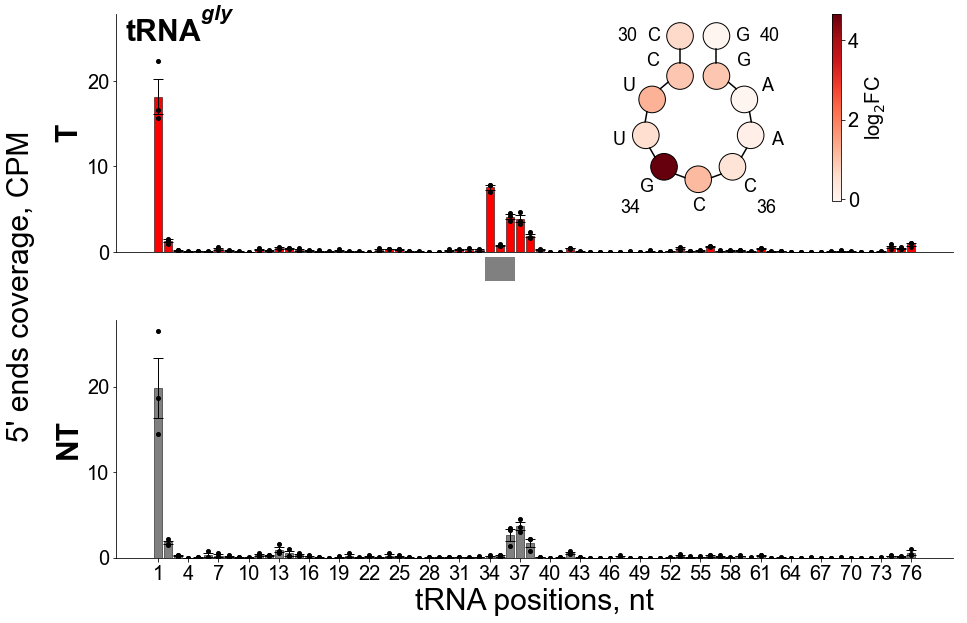

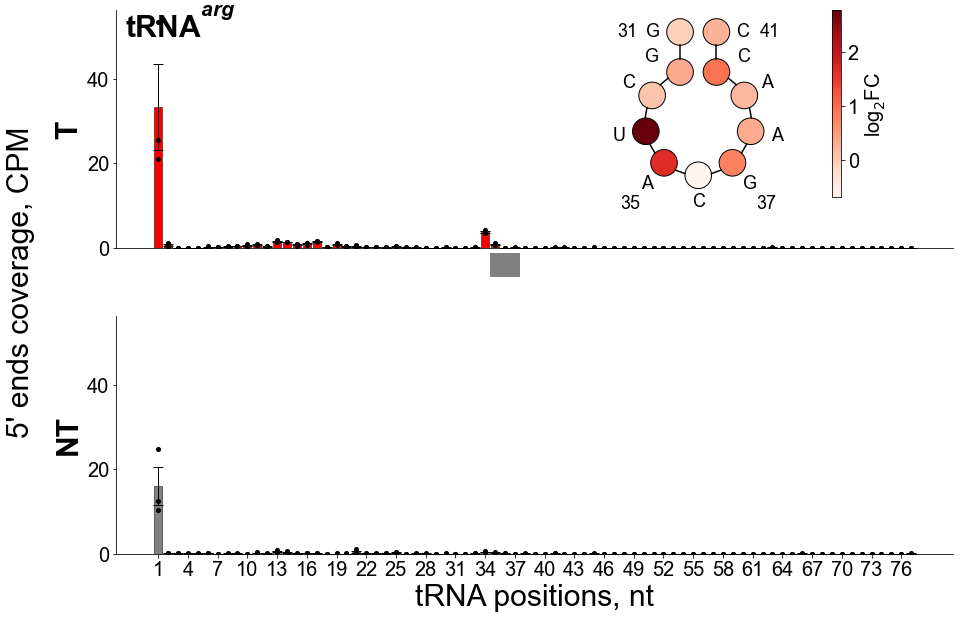

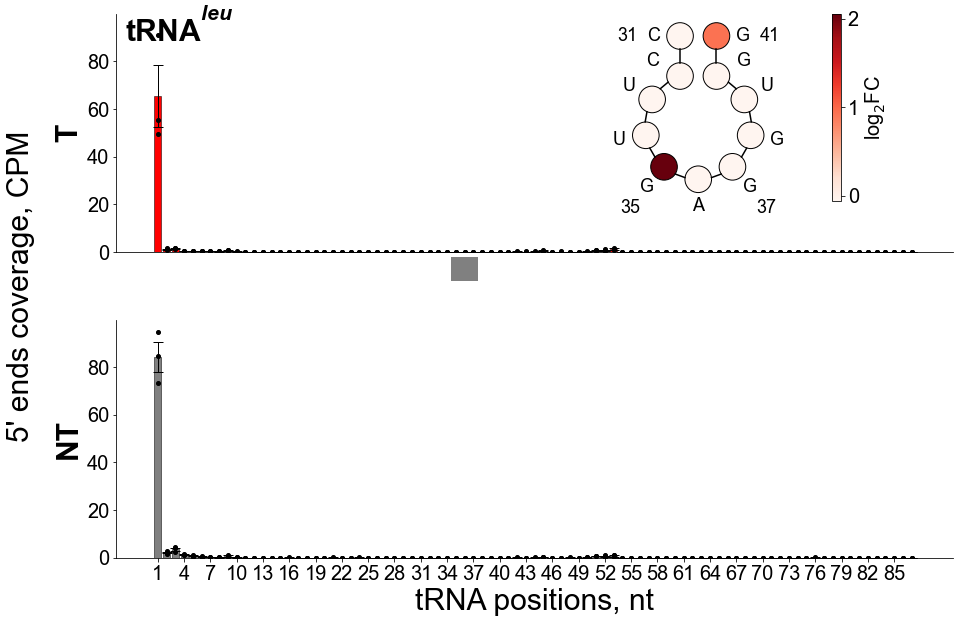

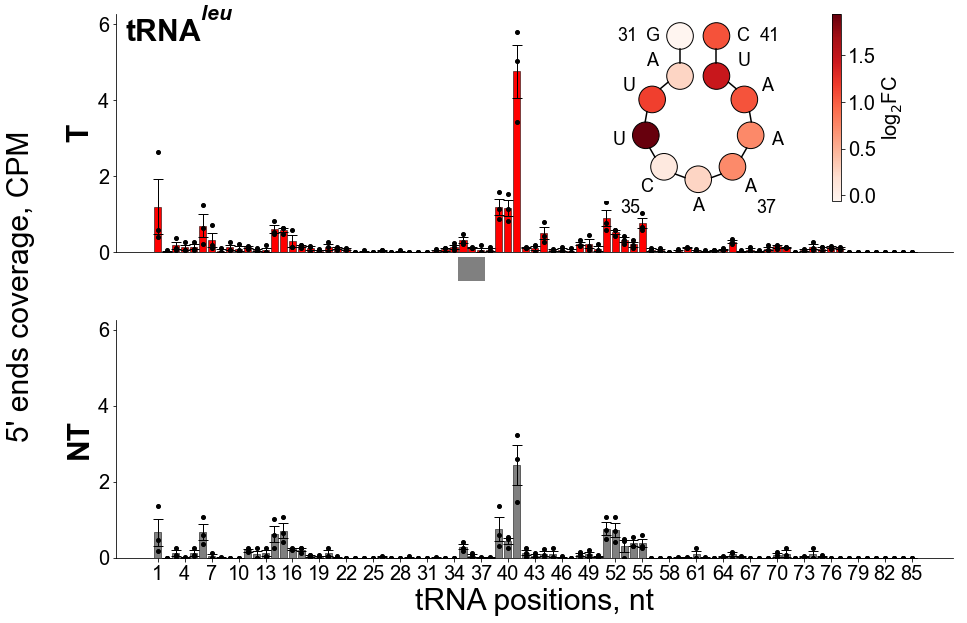

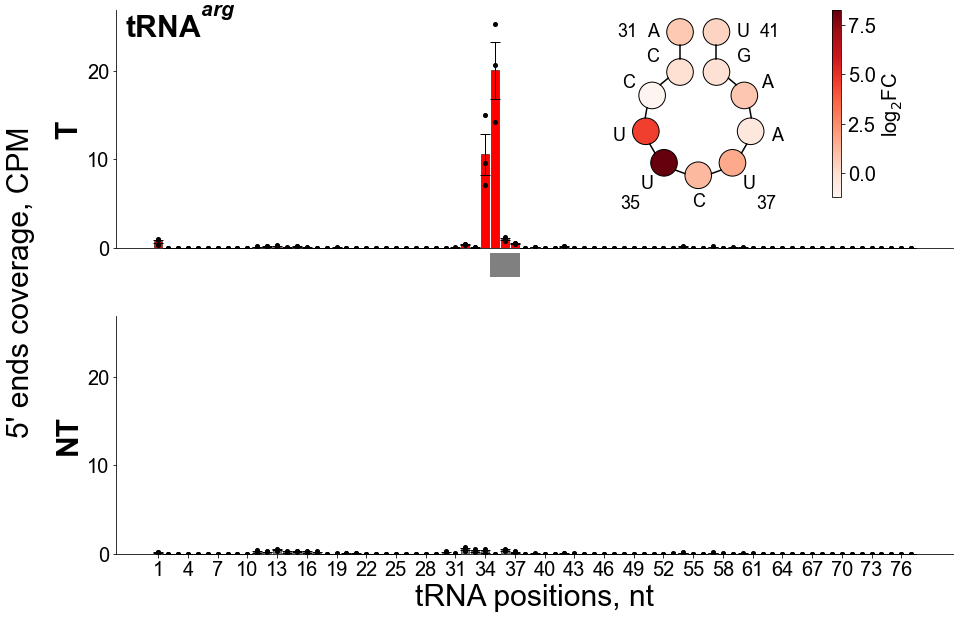

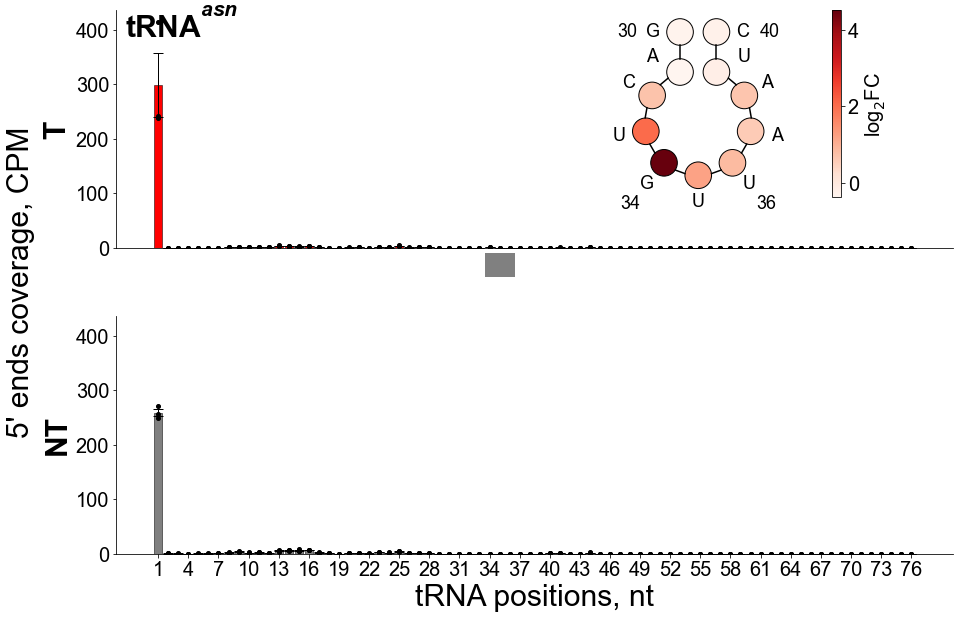

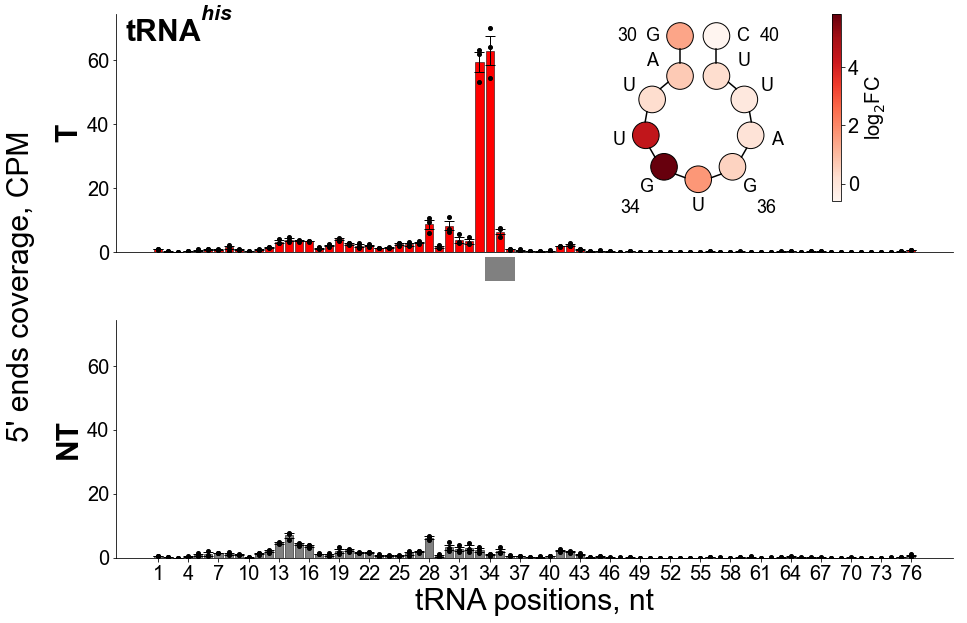

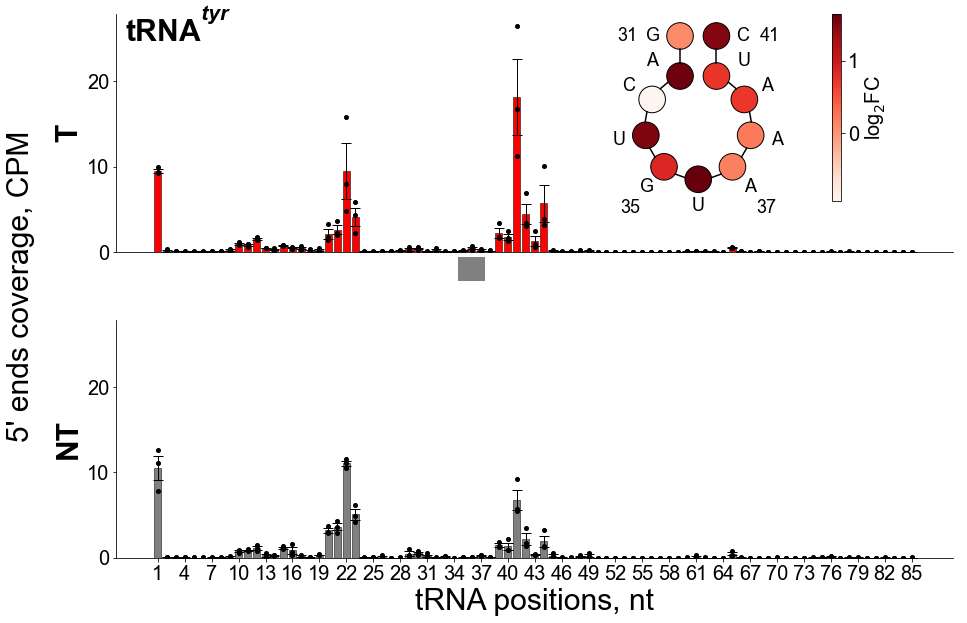

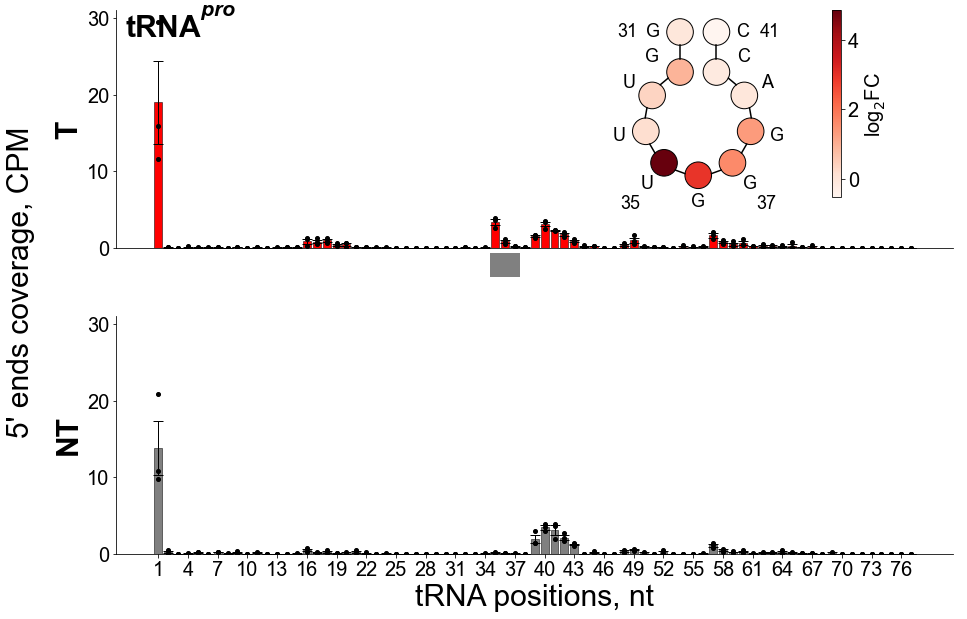

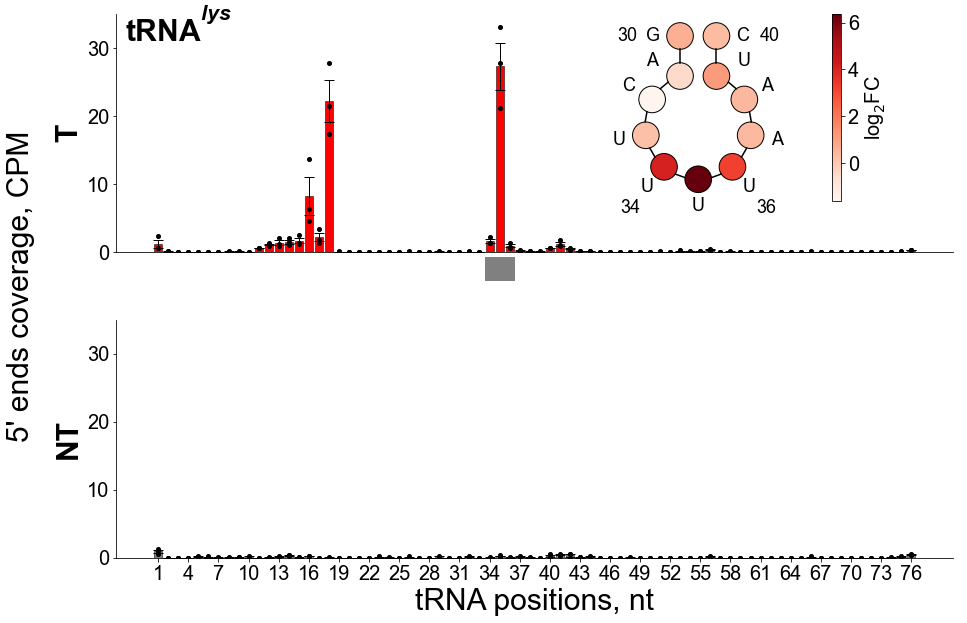

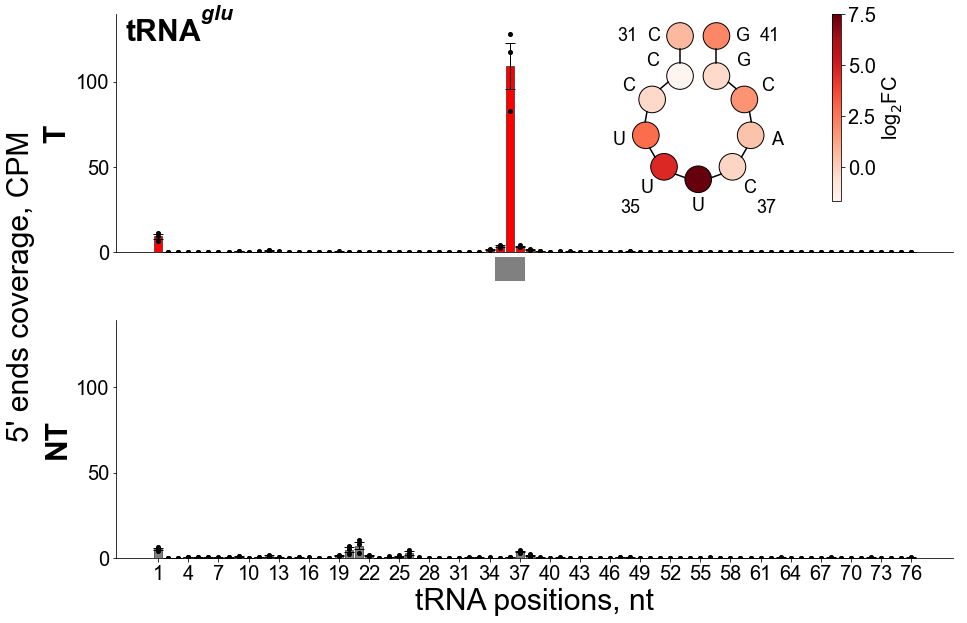

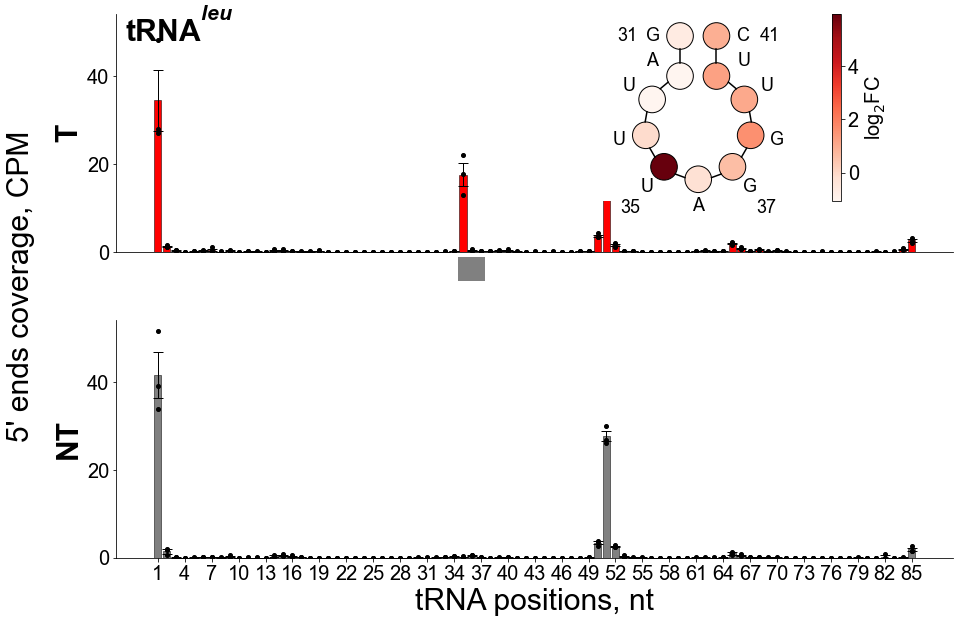

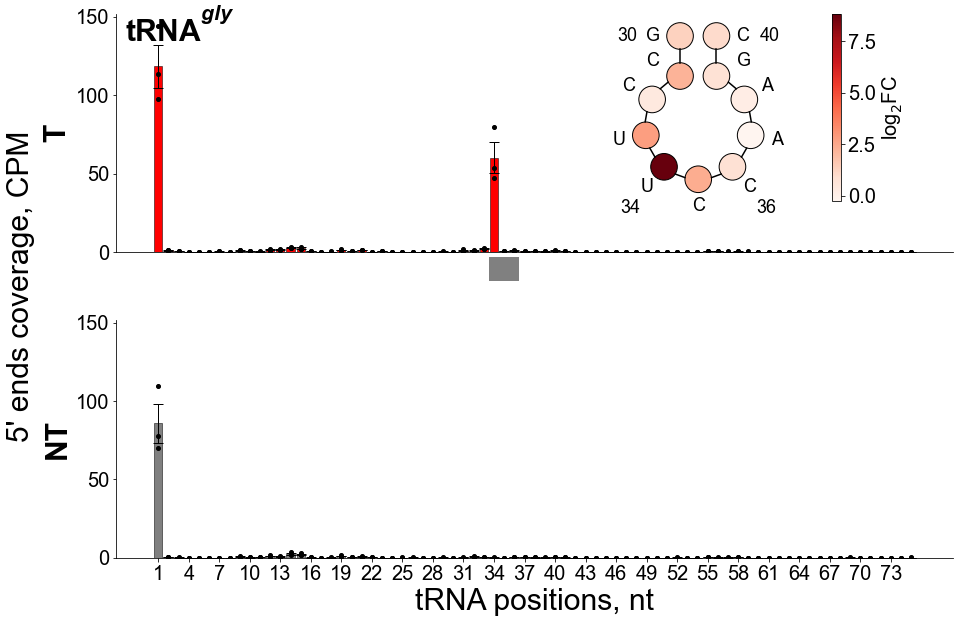

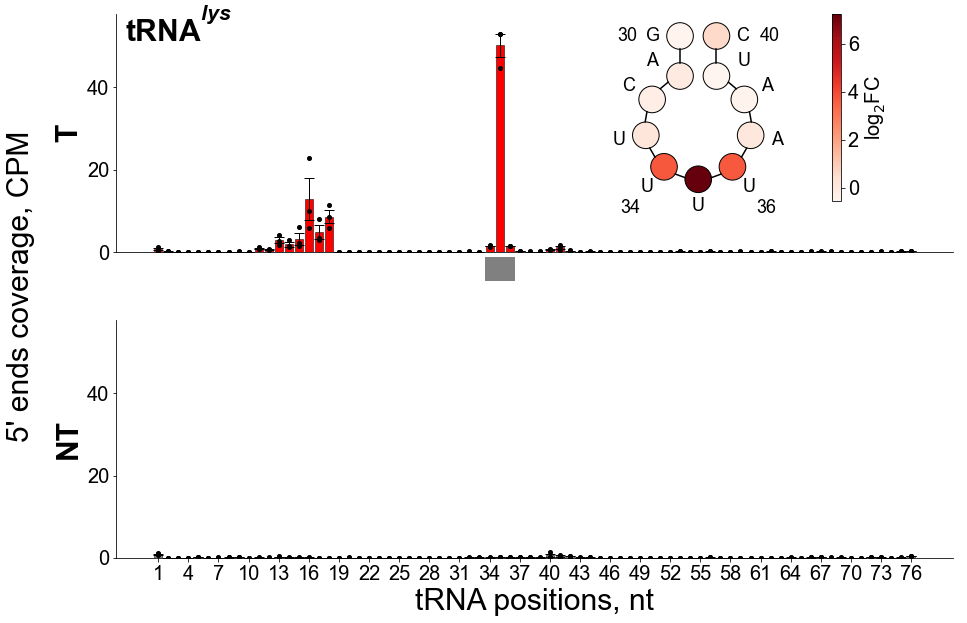

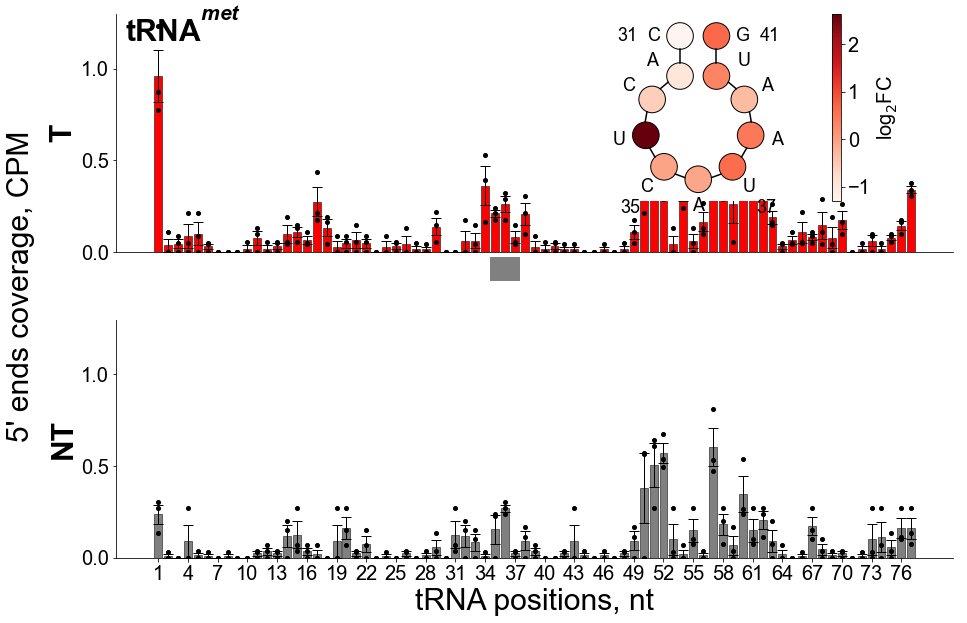

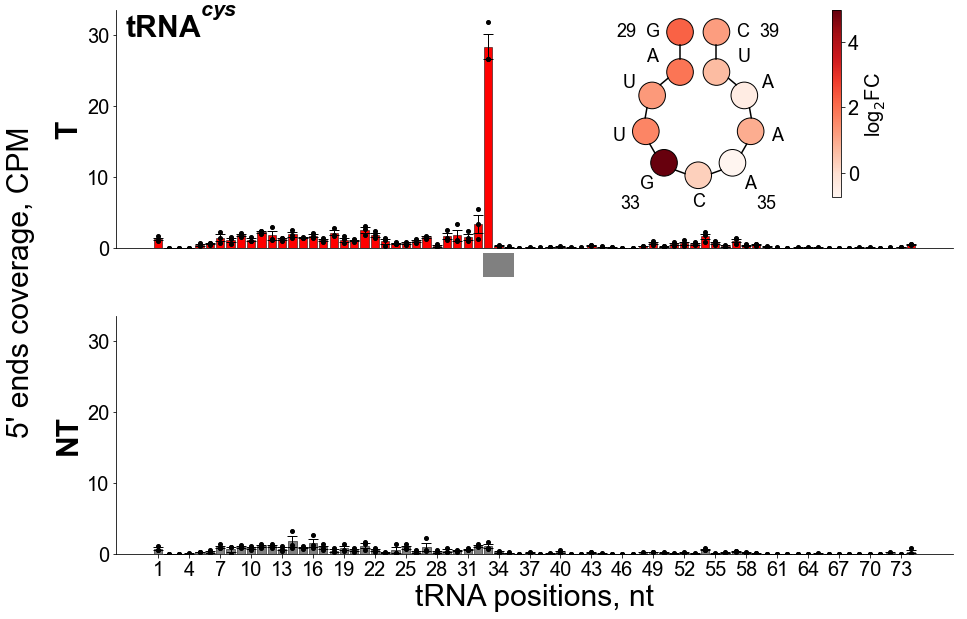

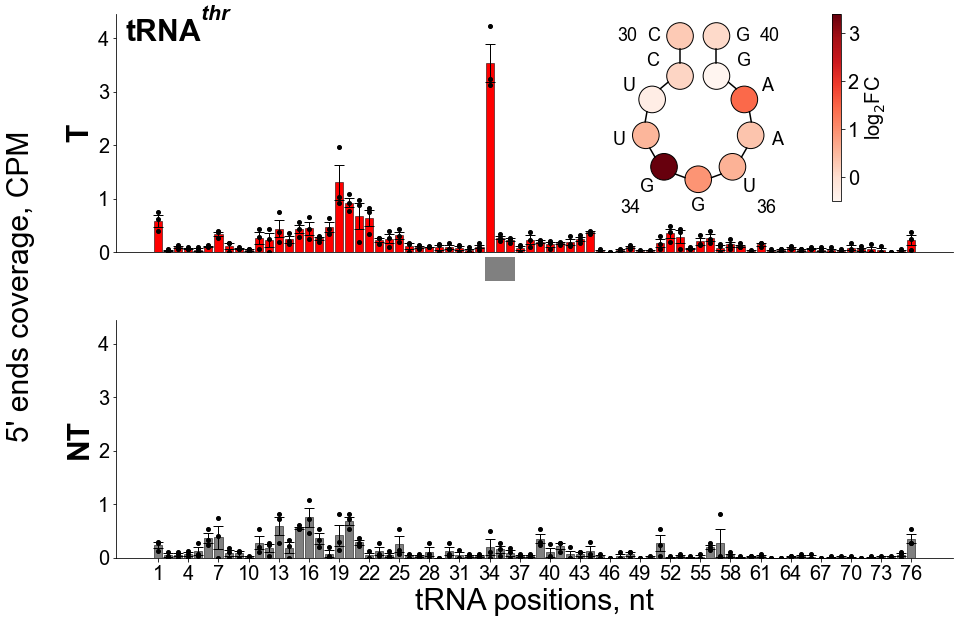

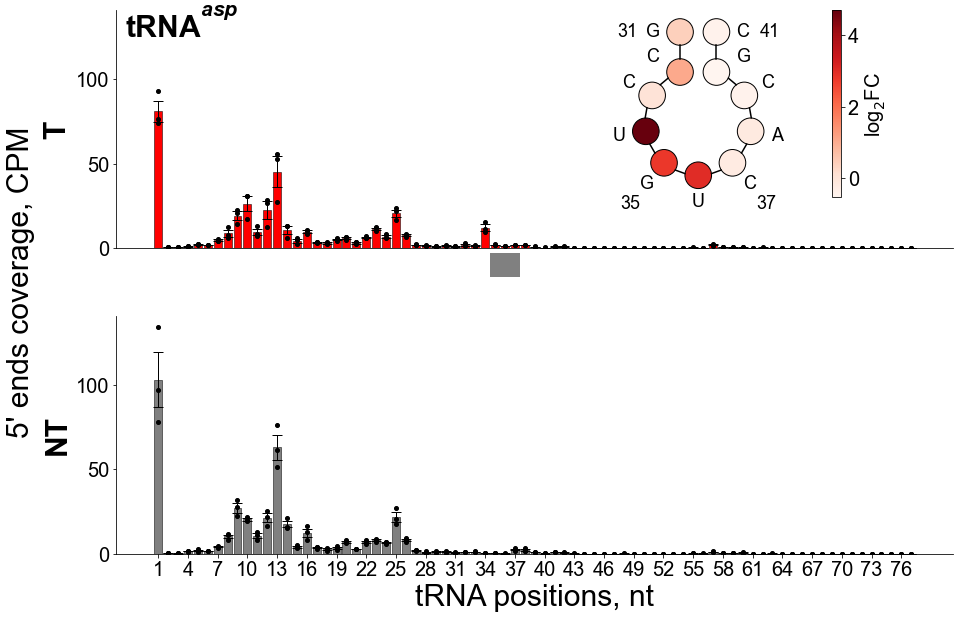

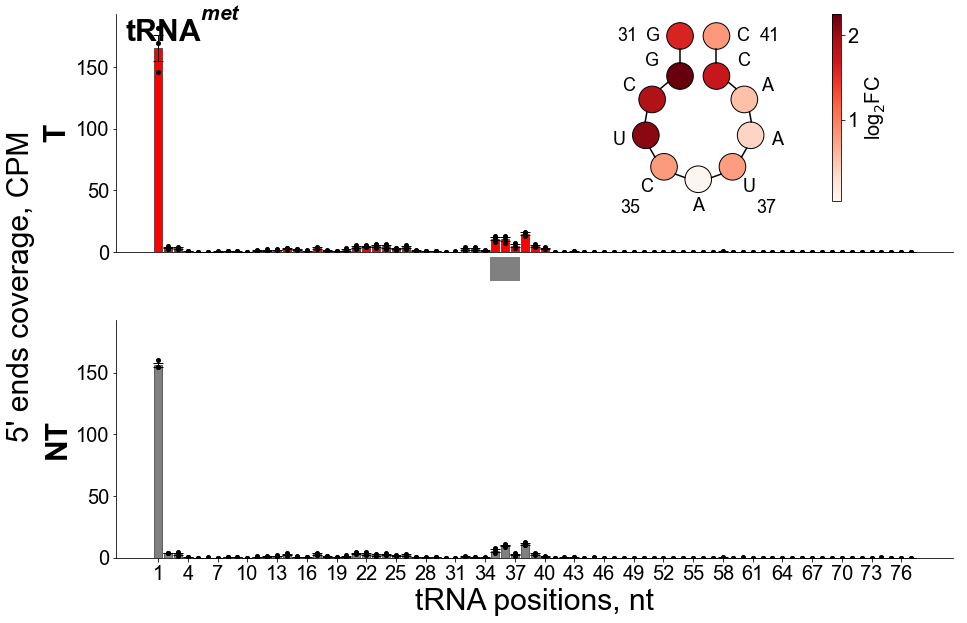

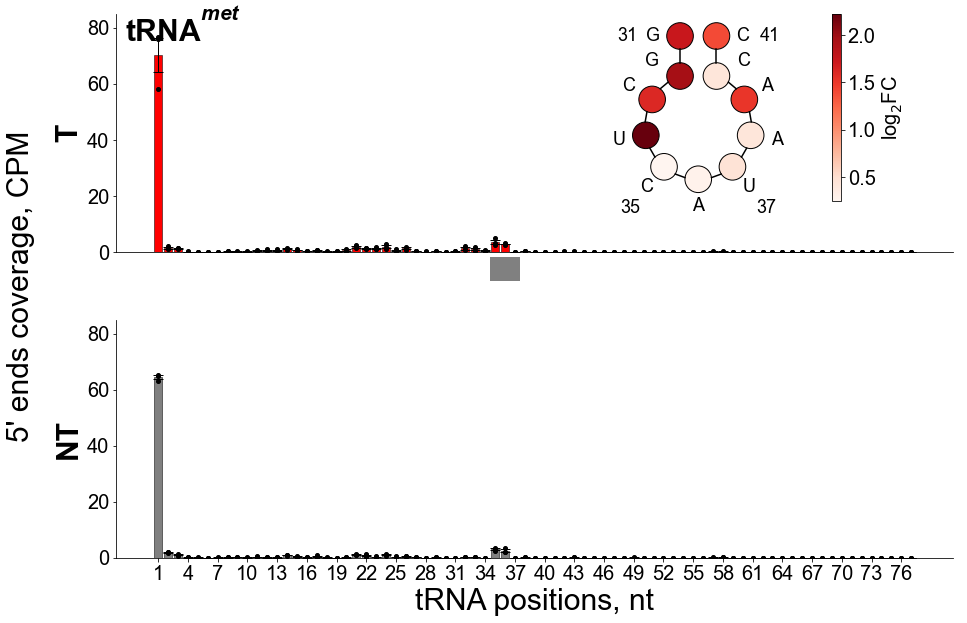

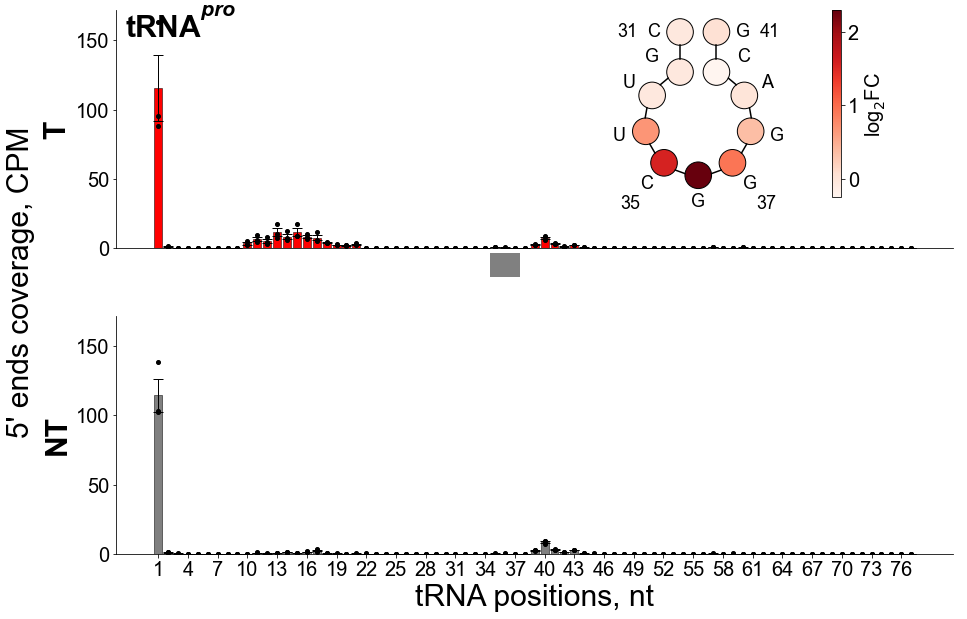

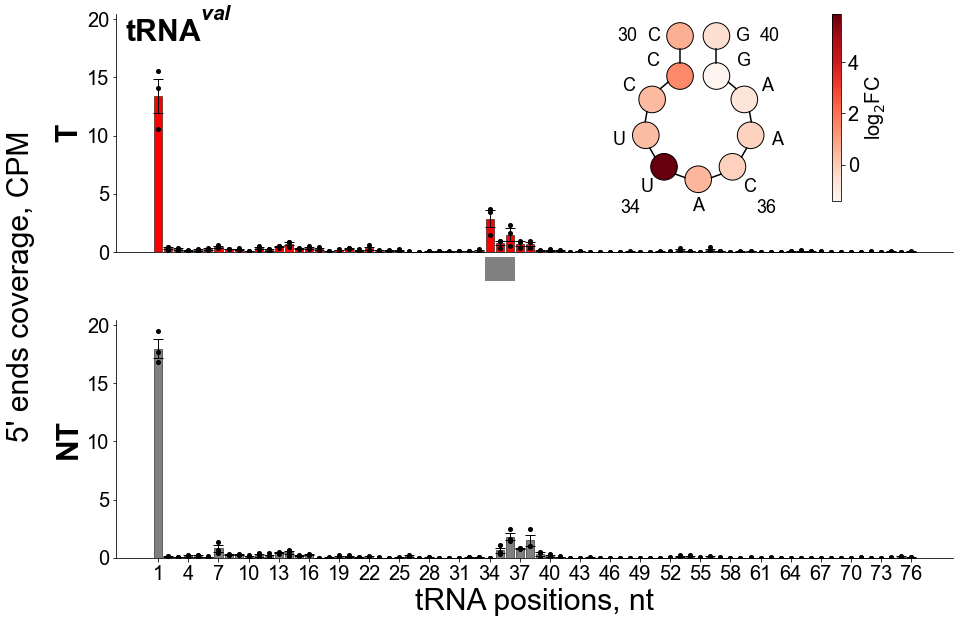

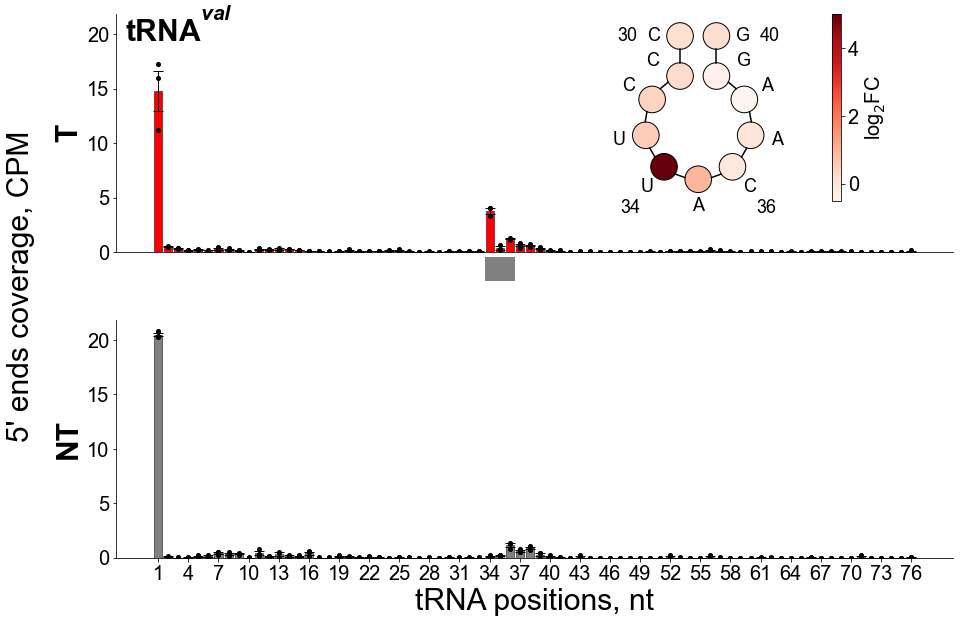

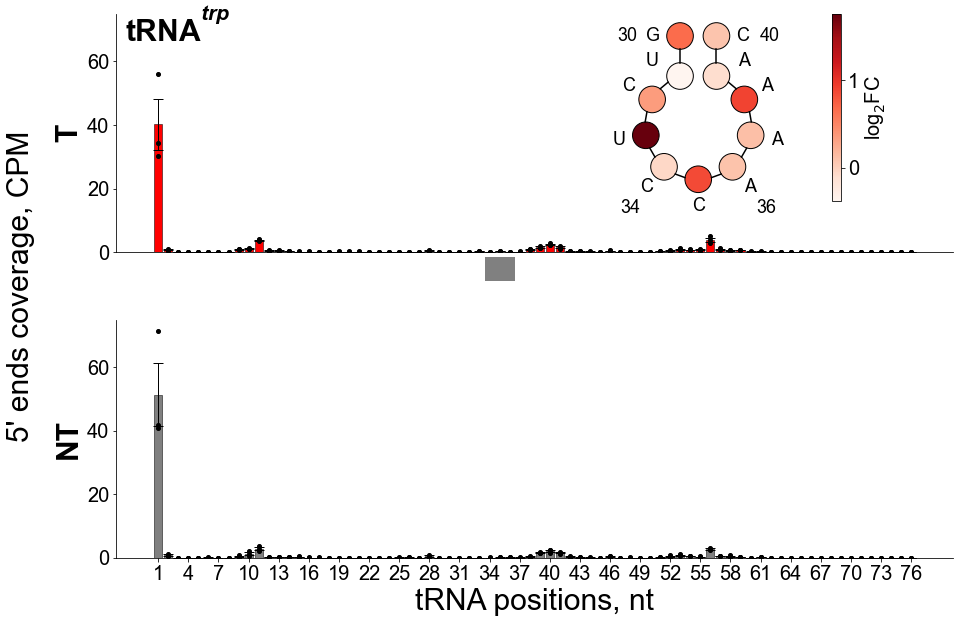

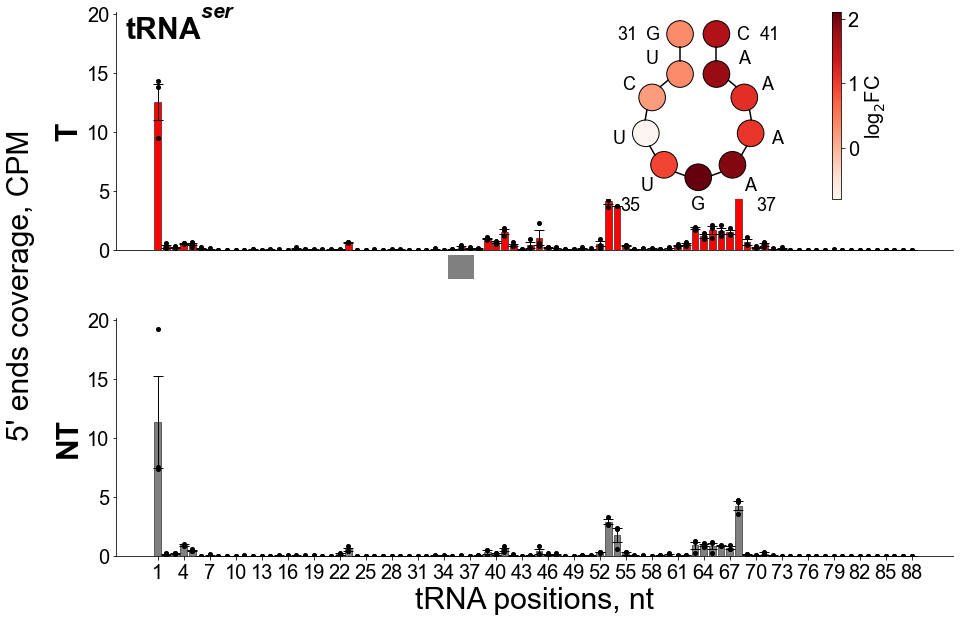

In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:italic:bold'
    
tRNA_N5E_counts_dir = "Results/Tables/Source_tables/tRNA_source_tables/"
tRNA_pictures_dir = "Results/Pictures/in_vitro_total_RNA_tRNA_cleavage_pictures/"

T_columns = DesignTable[DesignTable.Exp_group == "targeting"].Sample.tolist()
NT_columns = DesignTable[DesignTable.Exp_group == "nontargeting"].Sample.tolist()

for f in selected_tRNAs_list:
    file_path = os.path.join(tRNA_N5E_counts_dir, f)
    N5E_DF = pd.read_csv(file_path, sep="\t")

    AC_name_suffix = re.search("_(\d+)_(\d+)_(\d+).tsv", os.path.basename(file_path))
    AC_coords_array = [int(AC_name_suffix.group(i)) for i in range(1, 4)]
    tRNA_name = re.search("\d+-tRNA-(.*?)_\d+", os.path.basename(file_path)).group(1)
    output_file_path = os.path.join(tRNA_pictures_dir, "in_vitro_total_RNA_" + os.path.basename(file_path).rsplit(".")[0] + ".png")

    tRNA_plot_wrapper(TCS_df=N5E_DF, 
                      T_columns=T_columns, 
                      NT_columns=NT_columns, 
                      AC_coords_array=AC_coords_array, 
                      plot_label="tRNA$^{\mathbf{%s}}$" % tRNA_name.lower(), 
                      output_file_path=output_file_path)